In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matrixprofile import *
import seaborn as sns
import stumpy
from matrixprofile.discords import discords
import ast  # For parsing strings back to lists
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import cm

In [153]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'cleaned_time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)
print(len(X))

10000


**Analysis of the dataset to find motifs and/or anomalies**

# Matrix Profile (Overview)
• The Matrix Profile (MP) is a data structure that annotates a TS and
can be exploited for many purposed: e.g. efficient Motif Discovery.

## Here using matrixprofile library (the one given by the professor)

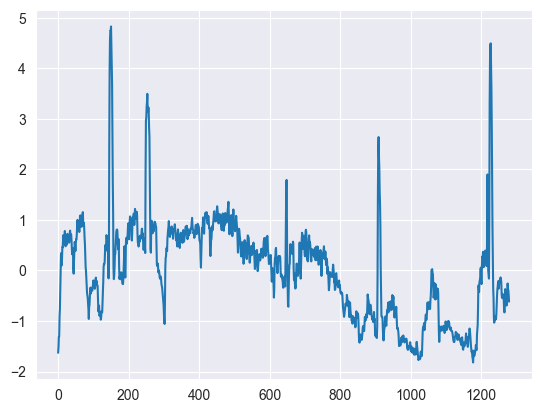

In [43]:
plt.plot(X[0,-1].T)
plt.show()

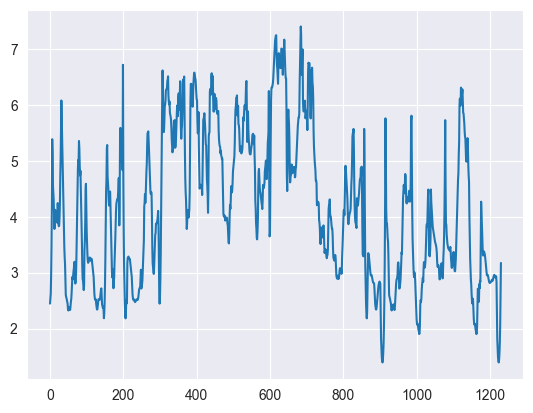

In [44]:
w = 50
ts = pd.Series(X[0,-1].T)
mp, mpi = matrixProfile.stomp(ts.values, w)
'''
The function *stomp* returns two arrays:
mp (Matrix Profile): An array where each element represents the smallest distance between a subsequence in the time series and its nearest, non-trivial matching subsequence.
mpi (Matrix Profile Index): An array of the indices where these minimum distances occur.
'''
plt.plot(mp)
plt.show()

## Here using stumpy library

In [45]:
X[0,-1].T

array([-1.62917158, -1.5209611 , -1.3132851 , ..., -0.39451296,
       -0.48918558, -0.61733393])

In [46]:
m = 50
y = X[0,-1].T
x = range(0,1280)
matrix_profile = stumpy.stump(y, m)

In [47]:
matrix_profile

array([[2.4463225322360587, 299, -1, 299],
       [2.5459000660221998, 299, -1, 299],
       [2.625772319111305, 300, -1, 300],
       ...,
       [2.0616009407164317, 911, 911, -1],
       [2.545789678780108, 912, 912, -1],
       [3.17308952017819, 913, 913, -1]], dtype=object)

In [48]:
matrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 'profile index', 'left profile index', 'right profile index'])

In [49]:
matrix_profile_df

profile profile index left profile index right profile index
0     2.446323           299                 -1                 299
1       2.5459           299                 -1                 299
2     2.625772           300                 -1                 300
3     2.933148           301                 -1                 301
4     3.458027           301                 -1                 301
...        ...           ...                ...                 ...
1226   1.56604           909                909                  -1
1227  1.751605           910                910                  -1
1228  2.061601           911                911                  -1
1229   2.54579           912                912                  -1
1230   3.17309           913                913                  -1

[1231 rows x 4 columns]

# Motif discovery (Overview)

## Using the matrix profile calculated by stumpy

The best motif is the one where the profile is the smallest (since the profile is the distance value)

Checking for the minimum will give us two matches, each of these should refer to each other which can be see by looking at the profile index:

In [50]:
best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motif

profile profile index left profile index right profile index
907   1.393428          1224                147                1224
1224  1.393428           907                907                  -1

We can plot this motif:

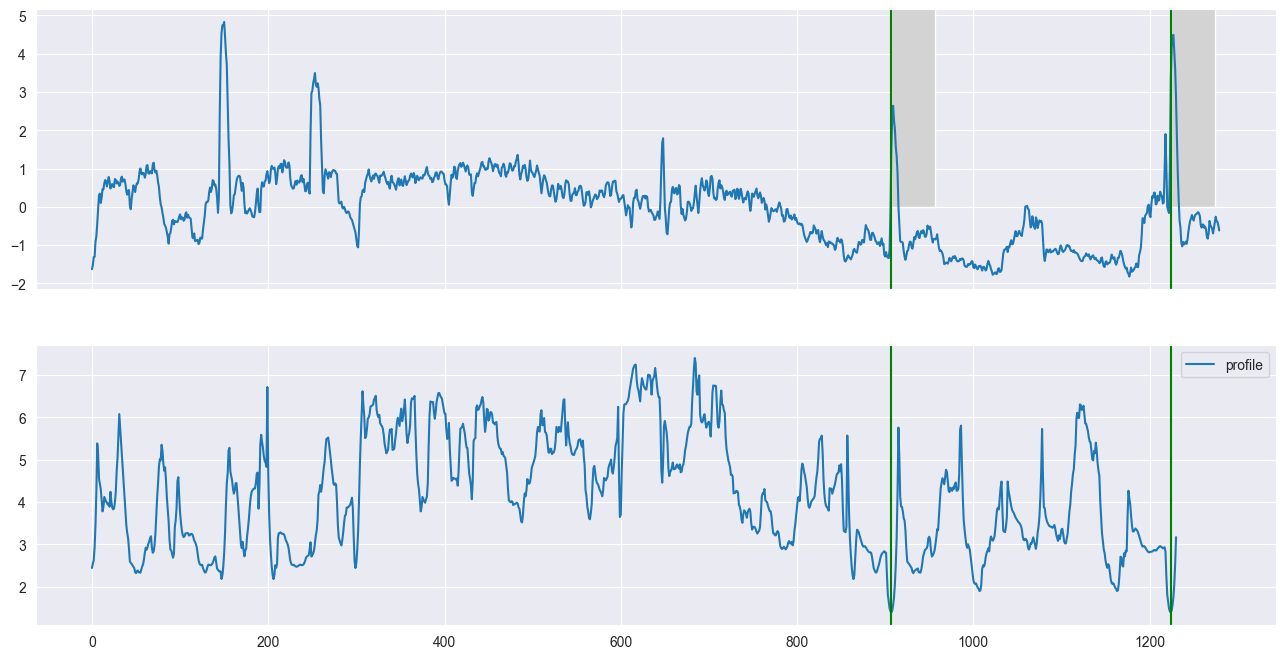

In [51]:
from matplotlib.patches import Rectangle

profile_df = matrix_profile_df[['profile']]

fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])

for idx in best_motif.index.to_list():
    g1.axvline(x=idx, color="green")
    g2.axvline(x=idx, color="green")
    rect = Rectangle((idx, 0), m, 40, facecolor="lightgrey")
    g1.add_patch(rect)

We can also see the above zoomed in:

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

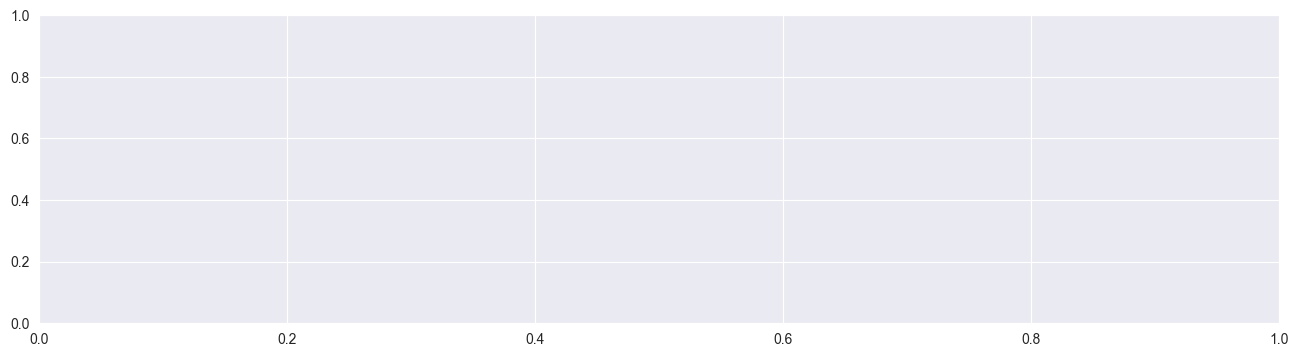

In [54]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in best_motif.index.to_list():
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

Comparatively, we can compare two random subsequences which don't have any specific relation



AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

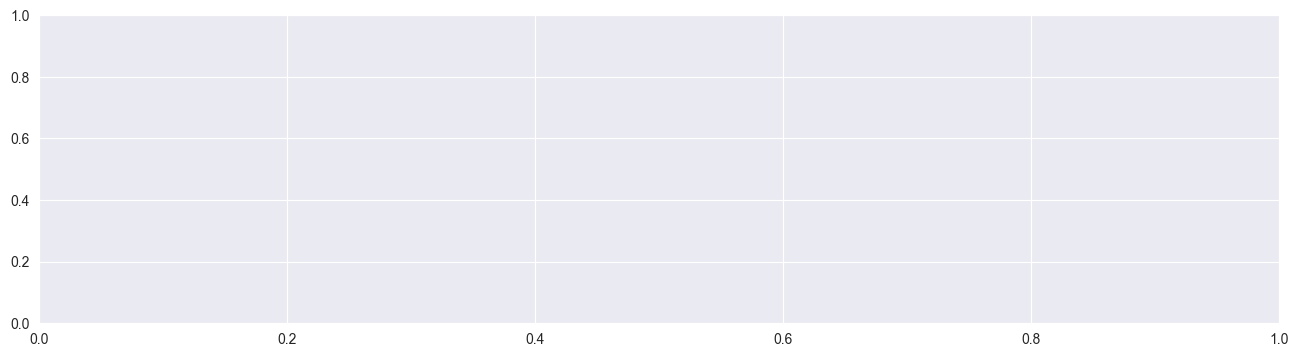

In [56]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in [0, 1000]:
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

## Find a discord/anomaly

Potential **discords/anomalies** can be located as data that's most different to any existing datapoints, this can be found by finding the max profile distance. We can find the anomaly segment by getting this value and plotting it below:

In [ ]:
discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
discord

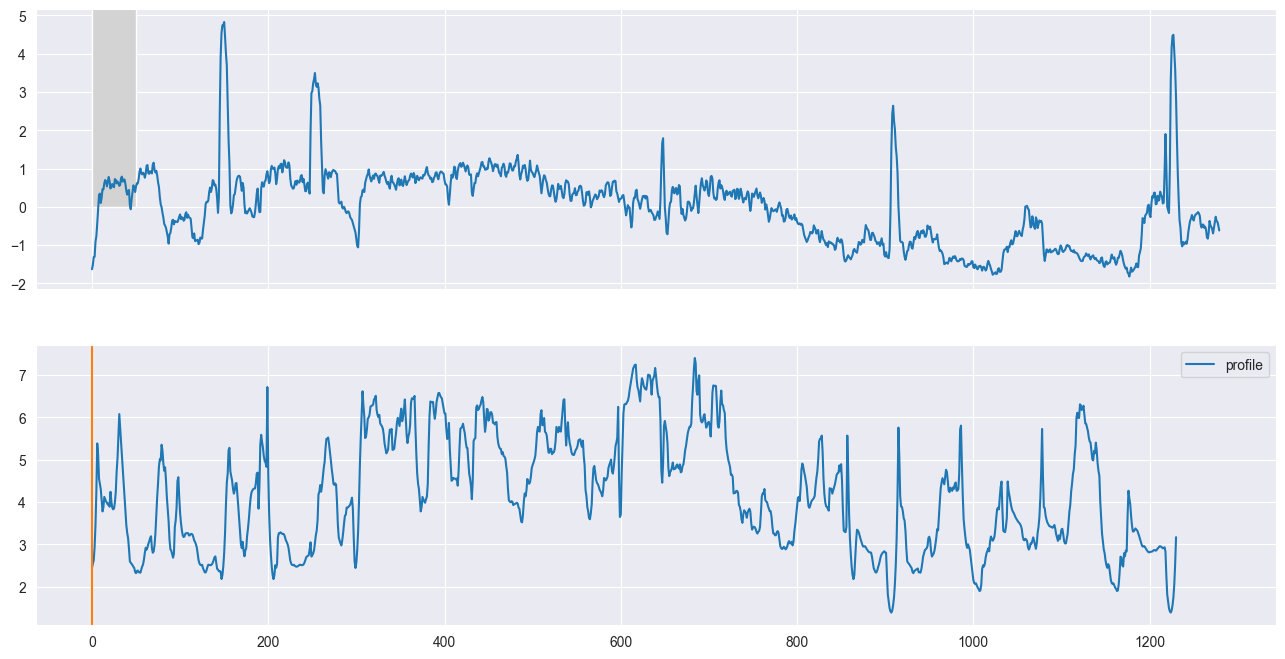

In [58]:
fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])


rect = Rectangle((discord.index[0], 0), m, 40, facecolor="lightgrey")
g1.add_patch(rect)
g2.axvline(x=[discord.index[0]], color='C1')

## Using the matrix profile calculated by matrixprofile library (the one given by the professor)

In [71]:
ts = pd.Series(X[0,-1].T)
mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=1)

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.


In [72]:
mo

[[147, 907, 1224]]

In [73]:
mod

[1.3934280967837902]

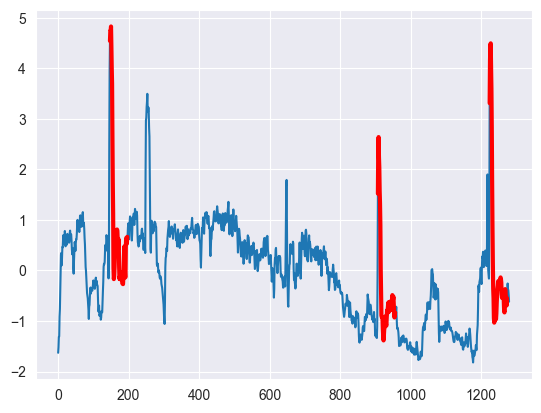

In [74]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

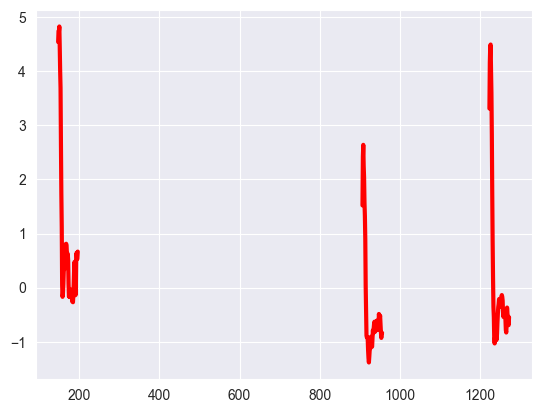

In [75]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

## find a discord/anomaly (using matrixprofile library) (the one given by the professor)

Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord    

Returns 
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [ ]:
anoms = discords(mp, ex_zone=3, k=1)

In [ ]:
anoms

In [ ]:
plt.plot(ts.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
x = ts.values
plt.plot(range(len(x)), x, marker='o', color='r')
plt.xticks(range(len(x)))
plt.grid()
plt.show()

In [ ]:
w = 3
mp = np.array([np.inf] * (len(x) - w + 1))
for i in range(len(x) - w + 1):
    #print('a', x[i:i+w])
    for j in range(len(x) - w + 1):
        if i == j:
            continue
        #print('b', x[j:j+w])
        val = 0
        for k in range(w):
            val += np.abs(x[i + k] - x[j + k])
        #print(val)
        mp[i] = min(mp[i], val)
    #print('')
        

In [ ]:
mp

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(mp, marker='o', color='b')
plt.xticks(range(len(mp)))
plt.grid()
plt.show()

In [ ]:
mp, mpi = matrixProfile.naiveMP(ts.values, m=12)

# Matrix Profile in entire dataset

## Using stumpy library

## Using matrixprofile library (the one given by the professor)

This code will find the best motif and discord for each time series in the dataset and save them to CSV files.

It's possibile to change the window size, number of motifs and number of discords to find by changing the values of `w`, `n_motifs` and `n_discords` respectively.

### Performing some noise reduction
Making it easier to identify true motifs (recurring patterns) and discords (anomalies).

In [154]:
# Noise reduction
w = 10
for i in range(len(X)):
    ts = pd.Series(X[i,-1].T)
    ts = ts.rolling(window=w).mean() # Noise (smoothing)
    X[i,-1] = ts.values

In [134]:
# Initialize the directory paths
best_motif_dir = 'best_motifs'
best_discord_dir = 'best_discord'

# Create directories if they don't exist
os.makedirs(best_motif_dir, exist_ok=True)
os.makedirs(best_discord_dir, exist_ok=True)

w = 50 # window size
n_motifs = 3 # number of motifs to find
n_discords = 2 # number of discords to find

# Normalize the time series

for i in range(len(X)):
    ts = pd.Series(X[i,-1].T)
    mp, mpi = matrixProfile.stomp(ts.values, w)
    mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=n_motifs)
    anoms = discords(mp, ex_zone=3, k=n_discords)


    motif_df = pd.DataFrame({'Motifs': [str(m) for m in mo]})
    motif_df.to_csv(os.path.join(best_motif_dir, f'best_motif_series_{i}.csv'), index=False)

    print(f"Best motif for {i}: {mo}")
    print(f"Discord for {i}: {anoms}")

    #best_motif.to_csv(f'best_motifs/best_motif_series_{i}.csv', index=False)
    discord_df = pd.DataFrame({'Discords': anoms})
    discord_df.to_csv(os.path.join(best_discord_dir, f'discord_series_{i}.csv'), index=False)

Best motif for 0: [[798, 1109], [1009, 1164], [51, 934]]
Discord for 0: [632 644]
Best motif for 1: [[171, 1205], [1006, 1178], [345, 1034]]
Discord for 1: [8 4]
Best motif for 2: [[1044, 1183], [963, 1017]]
Discord for 2: [791 364]
Best motif for 3: [[103, 368], [28, 179], [517, 1039]]
Discord for 3: [549 545]
Best motif for 4: [[925, 1165], [880, 1120]]
Discord for 4: [ 56 712]
Best motif for 5: [[817, 1154], [332, 490], [139, 372]]
Discord for 5: [560 930]
Best motif for 6: [[83, 355], [400, 442]]
Discord for 6: [634 623]
Best motif for 7: [[169, 442], [1126, 1230], [93, 1014]]
Discord for 7: [ 959 1172]
Best motif for 8: [[575, 728], [476, 779], [298, 1058]]
Discord for 8: [191 941]
Best motif for 9: [[130, 1128], [327, 937], [399, 1188]]
Discord for 9: [ 336 1016]
Best motif for 10: [[369, 1066], [215, 1012]]
Discord for 10: [574 415]
Best motif for 11: [[172, 921], [379, 631], [138, 1229]]
Discord for 11: [716 835]
Best motif for 12: [[167, 948], [478, 983], [290, 562]]
Discord f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


Best motif for 3130: [[560, 1007], [616, 1156]]
Discord for 3130: [865 426]
Best motif for 3131: [[474, 586], [446, 559], [885, 994]]
Discord for 3131: [944 132]
Best motif for 3132: [[154, 1118], [286, 611]]
Discord for 3132: [ 391 1096]
Best motif for 3133: [[13, 297], [58, 342]]
Discord for 3133: [542 545]
Best motif for 3134: [[119, 833], [368, 641], [92, 467]]
Discord for 3134: [1176 1005]
Best motif for 3135: [[1024, 1147], [133, 1195], [623, 792]]
Discord for 3135: [502 225]
Best motif for 3136: [[762, 1039], [370, 973]]
Discord for 3136: [1101   95]
Best motif for 3137: [[29, 153]]
Discord for 3137: [ 223 1180]
Best motif for 3138: [[472, 641], [129, 817]]
Discord for 3138: [891 993]
Best motif for 3139: [[220, 847], [75, 294], [481, 697]]
Discord for 3139: [1086  432]
Best motif for 3140: [[355, 727], [841, 1213]]
Discord for 3140: [1085 1078]
Best motif for 3141: [[363, 671], [337, 645]]
Discord for 3141: [838 929]
Best motif for 3142: [[340, 781], [212, 654], [167, 609]]
Dis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning: divide by zero encountered in divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matrixprofile/utils.py:200: RuntimeWarning: invalid value encountered in divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))


Best motif for 7154: [[151, 717], [123, 370], [47, 634]]
Discord for 7154: [792 835]
Best motif for 7155: [[171, 900], [274, 1203]]
Discord for 7155: [465 468]
Best motif for 7156: [[316, 1140], [585, 1073], [33, 491]]
Discord for 7156: [348 467]
Best motif for 7157: [[150, 216]]
Discord for 7157: [110  96]
Best motif for 7158: [[32, 898], [233, 639], [966, 1161]]
Discord for 7158: [118 559]
Best motif for 7159: [[309, 513], [829, 931], [189, 392]]
Discord for 7159: [1186 1189]
Best motif for 7160: [[93, 371], [59, 863]]
Discord for 7160: [1127  780]
Best motif for 7161: [[462, 798], [424, 760]]
Discord for 7161: [5 0]
Best motif for 7162: [[524, 920], [1084, 1218], [396, 858]]
Discord for 7162: [992 988]
Best motif for 7163: [[352, 921], [169, 846], [292, 1156]]
Discord for 7163: [642  22]
Best motif for 7164: [[217, 415], [77, 127]]
Discord for 7164: [ 545 1156]
Best motif for 7165: [[566, 976], [6, 259], [891, 948]]
Discord for 7165: [785 745]
Best motif for 7166: [[613, 920], [882,

This code will load the best motifs and discords for each time series from the CSV files and combine them into two DataFrames: one for motifs and one for discords.

In [135]:
# Number of time series
num_series = 3

# Initialize empty DataFrames for motifs and discords
all_motifs = pd.DataFrame()
all_discords = pd.DataFrame()

# Loop through each time series to gather motifs and discords
for i in range(len(X)):
    # Load motifs and discords from CSV
    best_motif = pd.read_csv(f'best_motifs/best_motif_series_{i}.csv')
    discord = pd.read_csv(f'best_discord/discord_series_{i}.csv')

    # Add a column for series identifier
    best_motif['index'] = i
    best_motif['id'] = ids[i]
    best_motif['genre'] = y[i]
    discord['index'] = i
    discord['id'] = ids[i]
    discord['genre'] = y[i]
    
    # Append the motifs and discords to the respective data frames
    all_motifs = pd.concat([all_motifs, best_motif], ignore_index=True)
    all_discords = pd.concat([all_discords, discord], ignore_index=True)

# Reset index of the final data frames
all_motifs.reset_index(drop=True, inplace=True)
all_discords.reset_index(drop=True, inplace=True)

# Now 'all_motifs' and 'all_discords' DataFrames contain all motifs and discords from all series respectively

Now that we have found the best motifs and discords for each time series, we can plot them. First of all we have to load the motifs and discords from the CSV files and then plot them.

In [ ]:
# Number of time series
num_series = 3

colors = ['g', 'k', 'b', 'y']
# Plotting each series' motifs and discords
for i in range(num_series):
    # Load motifs and discords from CSV
    best_motif = pd.read_csv(f'best_motifs/best_motif_series_{i}.csv')
    discord = pd.read_csv(f'best_discord/discord_series_{i}.csv')

    # Assuming you have the original time series data in 'X'
    y = X[i, -1].T
    

    # Create a plot for the time series and its motifs/discords
    plt.figure(figsize=(14, 5))
    plt.title(f"Time Series {i} - Motifs and Discords")
    plt.plot(y, label='Time Series', color='lightgray')

    # Highlight motifs and discords
    color_index = 0
    for index, motif in enumerate(best_motif['Motifs']):
        motif_indices = ast.literal_eval(motif)  # Convert string back to list
        color = colors[color_index % len(colors)]  # Cycle through colors if there are more motifs than colors
        for start_index in motif_indices:
            plt.plot(range(start_index, start_index + w), y[start_index:start_index + w], label=f'Motif {index + 1}', color=color)
        plt.plot([], [], color=color, label=f'Motif {index + 1}', linewidth=3)  # Add legend entry
        color_index += 1


    # Highlight discords
    for discord_index in discord['Discords']:
        start_index = int(discord_index)
        plt.plot(range(start_index, start_index + w), y[start_index:start_index + w], label='Discord', color='red')


    # Ensure legends are not repeatedly added
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

Now we create a new column in the all_motifs dataframe that contains the number of times each motif is duplicated in the dataframe. We then sort the motifs by the number of duplicates and plot the motifs for each series.

In [136]:
# In the all_motifs dataframe, create a new column 'n_duplicated' that contains the number of times each motif is duplicated in the dataframe
all_motifs['n_duplicated'] = all_motifs.duplicated(subset='Motifs', keep=False).groupby(all_motifs['Motifs']).transform('sum')

# Sort the motifs by the number of duplicates
all_motifs.sort_values('n_duplicated', ascending=False, inplace=True)

all_motifs.sort_values(by=['Motifs','n_duplicated', 'index'], ascending=[True,False, True], inplace=True)

In [158]:
all_motifs

Motifs  index                      id              genre  \
14897    [0, 1002]   6331  7wWrh9TNJYmIicCg8fupuz               goth   
22179    [0, 1065]   9464  18ywhG9EvuMMUIdUWxEqp7         songwriter   
21392    [0, 1165]   9126  4URpvnAgMxnWgjqalOPuUG         honky-tonk   
11659     [0, 121]   4960  2pcV9xZcsvwQsXRR1ole1n        world-music   
6455      [0, 151]   2752  0xgwhUNd8RBPLvjGr3CnU9        heavy-metal   
...            ...    ...                     ...                ...   
5490   [999, 1138]   2349  4ll52DVB6XfikzptojIPKm               goth   
4466   [999, 1147]   1911  2AYWQMI8f2zUXV3EG4vZYH          synth-pop   
16124  [999, 1150]   6856  2LkchfaYkfpPpkehlAzryf                emo   
10198  [999, 1154]   4342  5VBeV2QWi3zsr7t5nRvNWQ     minimal-techno   
20193  [999, 1219]   8616  4XMf6BjWH7Pme8eY4yyEZE  progressive-house   

       n_duplicated  
14897             0  
22179             0  
21392             0  
11659             0  
6455              0  
...             ...  
5490              0  
4466              0  
16124             0  
10198             0  
20193             0  

[23437 rows x 5 columns]

In [137]:
motif_copy = all_motifs[all_motifs['n_duplicated'] > 2]
motif_copy

Motifs  index                      id           genre  \
2232   [1000, 1192]    948  4WPC9MrVbtnpxcKFDyouit         new-age   
9308   [1000, 1192]   3965  4WPC9MrVbtnpxcKFDyouit           piano   
16903  [1000, 1192]   7193  5119q7EHJi4C9fxZLkr4i2           opera   
5127   [1023, 1230]   2189  6n1vYUIisGSlawZTVgy2Po             mpb   
16590  [1023, 1230]   7058  4uCrjrbmEah80ytzLJvKdn           salsa   
...             ...    ...                     ...             ...   
8834    [963, 1230]   3763  61dgKii1YUE2sS7SZk00Ky  minimal-techno   
23343   [963, 1230]   9959  46MhfQQxeAHPhycIbDs9Gc          j-idol   
6207    [995, 1230]   2652  51xQ0wGnOR8Sy5ce2UmVLi     heavy-metal   
23252   [995, 1230]   9921  2YNgcIiD73XsXFNM3UuxlM            folk   
23296   [995, 1230]   9941  4U0rgCu3sVS4UvJ4cv6ueJ     world-music   

       n_duplicated  
2232              3  
9308              3  
16903             3  
5127              3  
16590             3  
...             ...  
8834              3  
23343             3  
6207              3  
23252             3  
23296             3  

[101 rows x 5 columns]

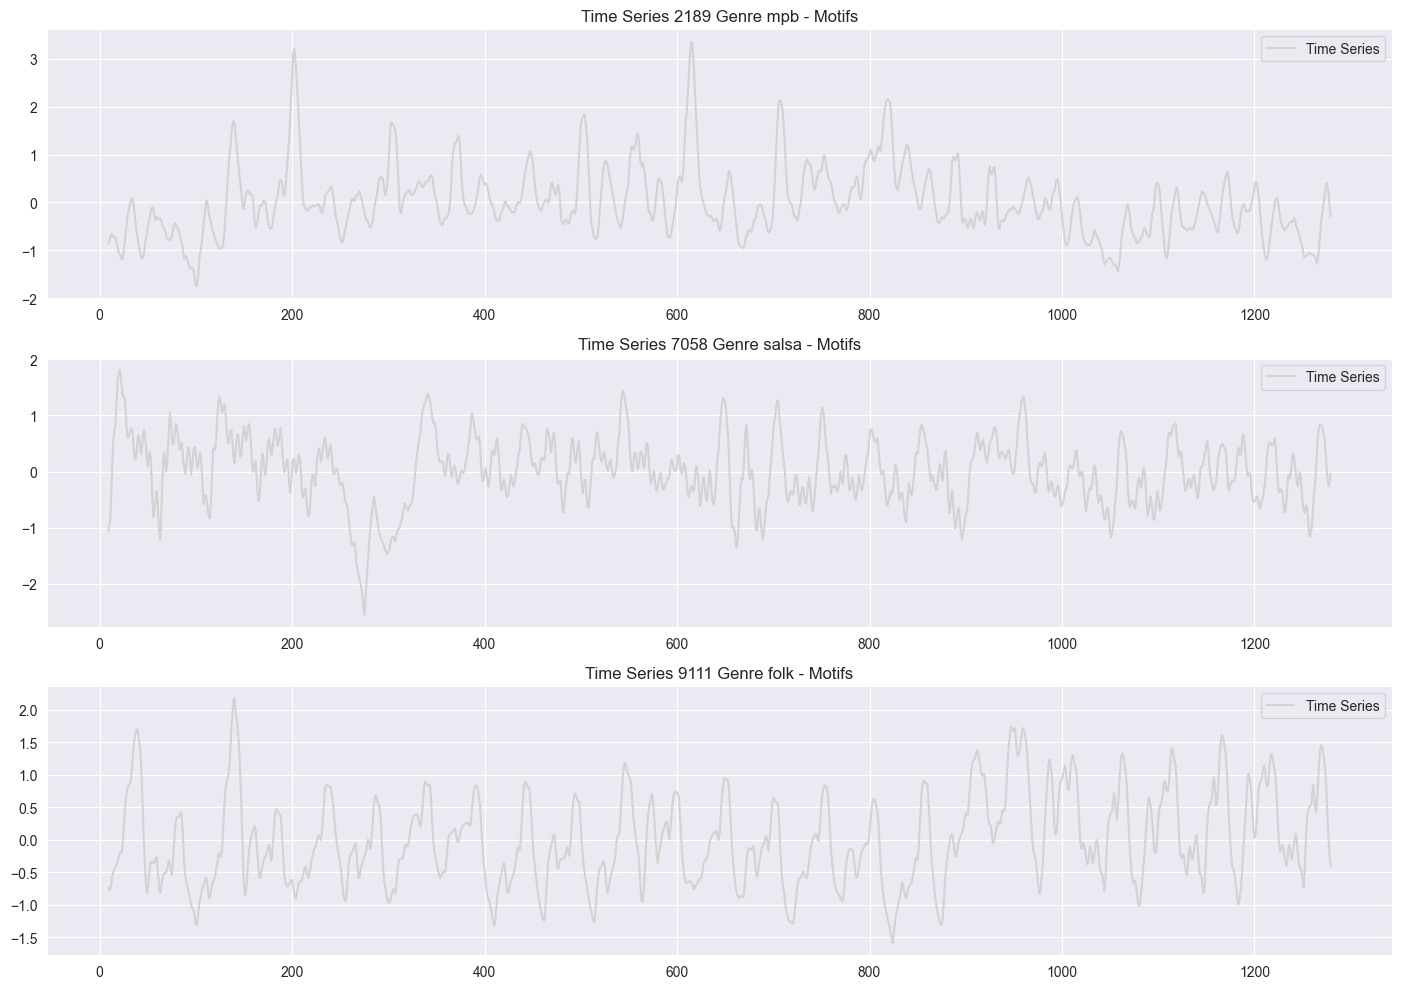

In [155]:
indices_to_plot = [2189, 7058, 9111]
w = 50  # Window size as per your previous code
colors = ['g', 'k', 'b', 'y']  # Colors for the motifs

# Create a figure with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

# Adjust the size of the bottom plot to take up more space
axs[2].get_position().set_points([[0.125, 0.125], [0.9, 0.5]])

motif_copy = all_motifs[all_motifs['n_duplicated'] > 3]
motif_copy = motif_copy.drop_duplicates(subset='id', keep='first')

for i, series_id in enumerate(indices_to_plot):
    best_motif = motif_copy[motif_copy['index'] == series_id]  # Filter motifs for the current series
    ts = X[series_id, -1].T  # Load the time series data
    axs[i].set_title(f"Time Series {series_id} Genre {y[series_id]} - Motifs")
    axs[i].plot(ts, label='Time Series', color='lightgray')  # Plot the time series
    # Highlight motifs
    color_index = 0
    for index, row in best_motif.iterrows():
        motif_indices = ast.literal_eval(row['Motifs'])
        color = colors[color_index % len(colors)]
        for start_index in motif_indices:
            axs[i].plot(range(start_index, start_index + w), ts[start_index:start_index + w], color=color)
        axs[i].plot([], [], color=color, label=f'Motif', linewidth=3)  # Add legend entry for each motif
        color_index += 1

    # Adding a legend to each subplot
    axs[i].legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

### Now let's plot the most common motifs (with a threshold) 

4WPC9MrVbtnpxcKFDyouit
new-age


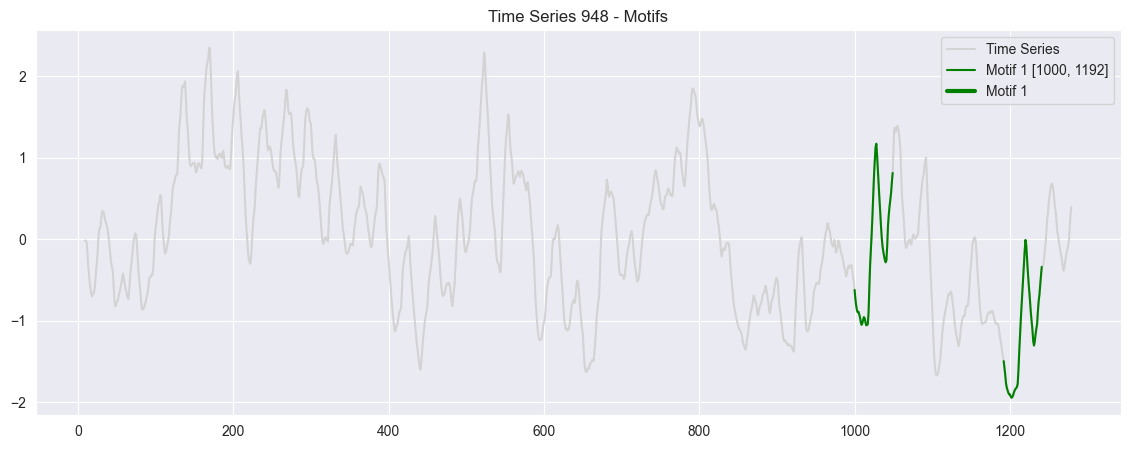

5119q7EHJi4C9fxZLkr4i2
opera


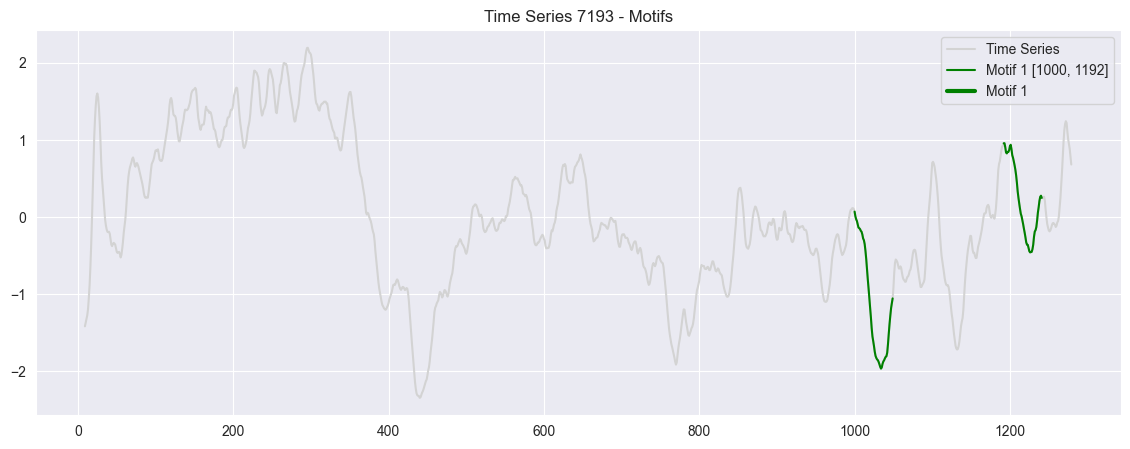

6n1vYUIisGSlawZTVgy2Po
mpb


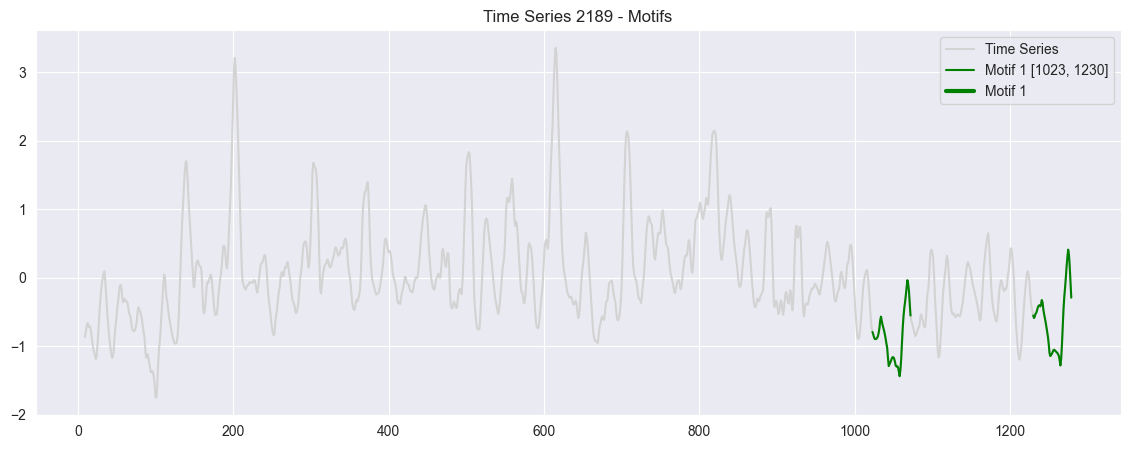

4uCrjrbmEah80ytzLJvKdn
salsa


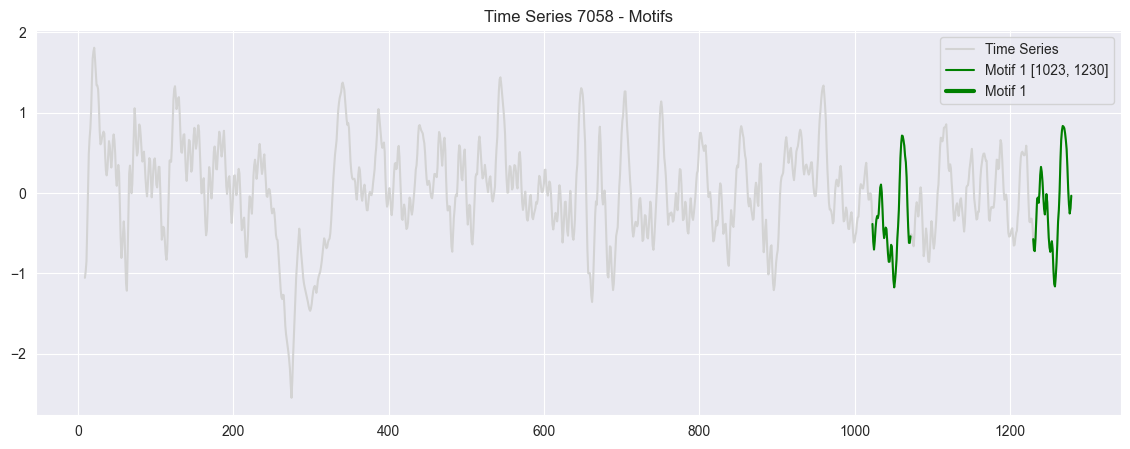

5wNpnKRUxbPoIpDXFZ5NkU
folk


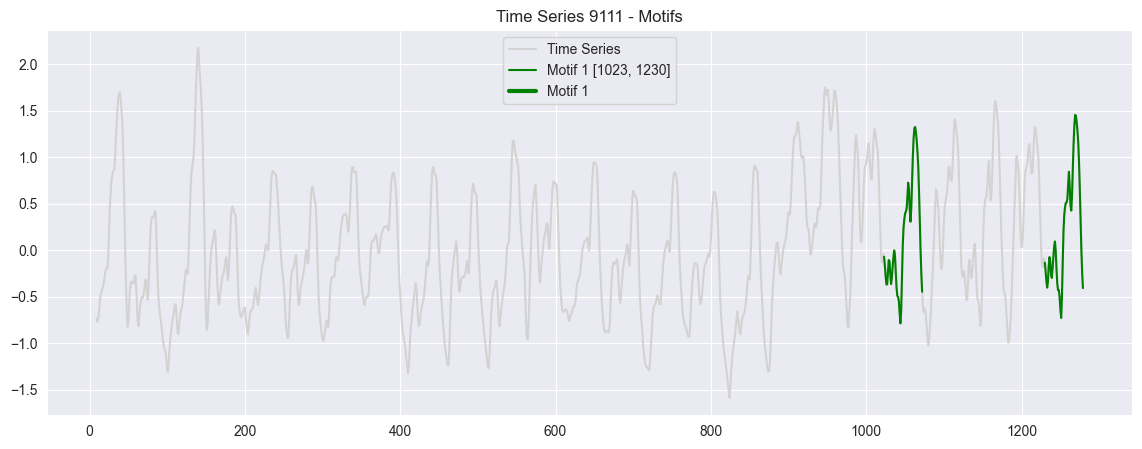

22aoAzWBmrDlbDLNjTTJ6F
minimal-techno


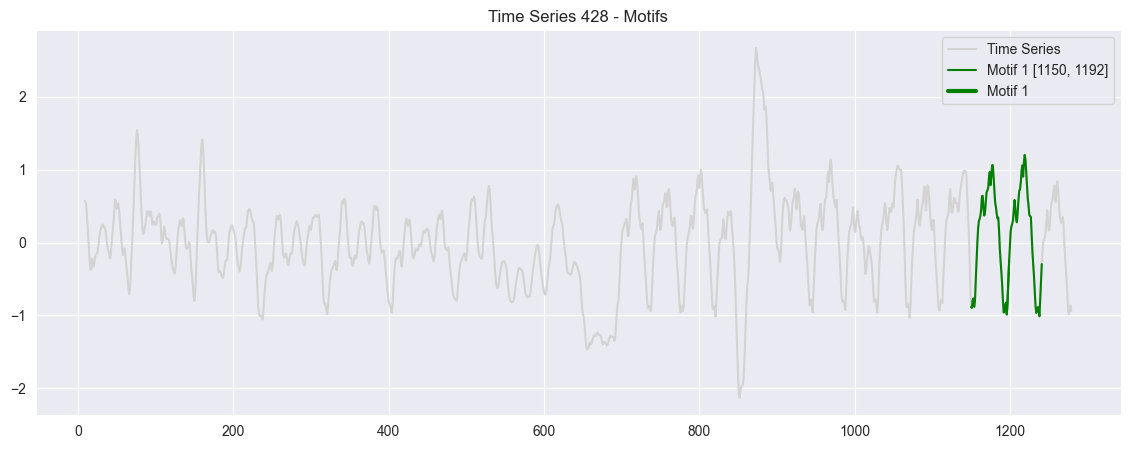

6sXzl29WqFoy5F91n8nV9i
honky-tonk


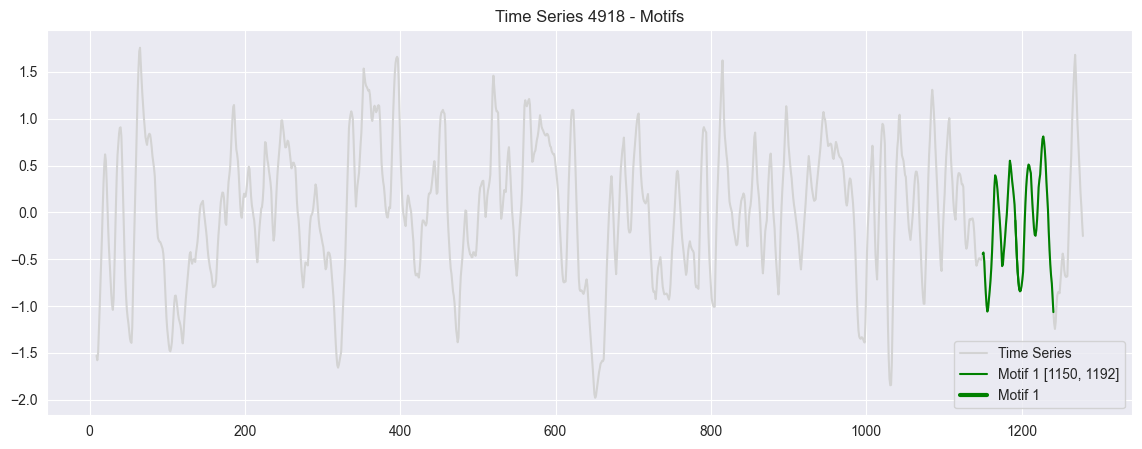

2g96s7bUTE15xXW3Gnkvr3
minimal-techno


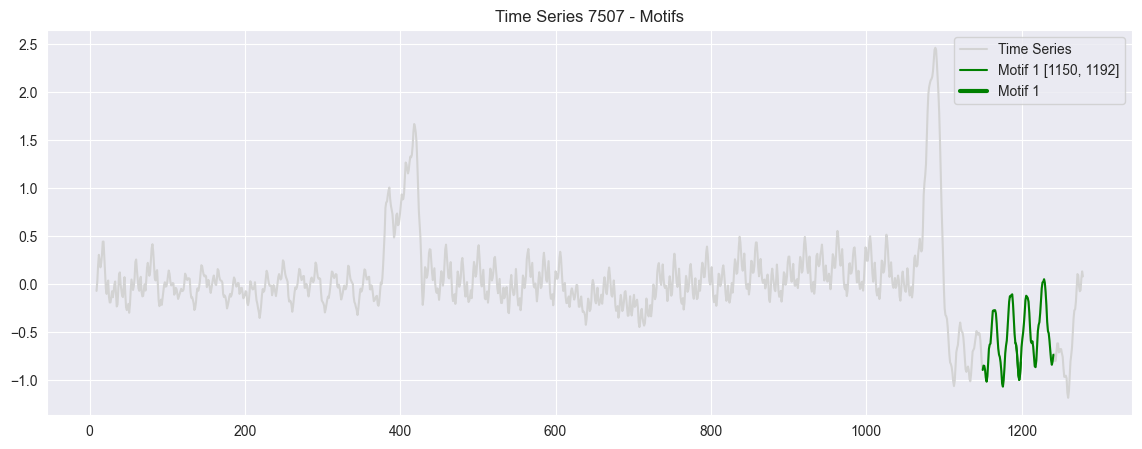

6ge78YSB7wKmJy5zds5oeE
j-idol


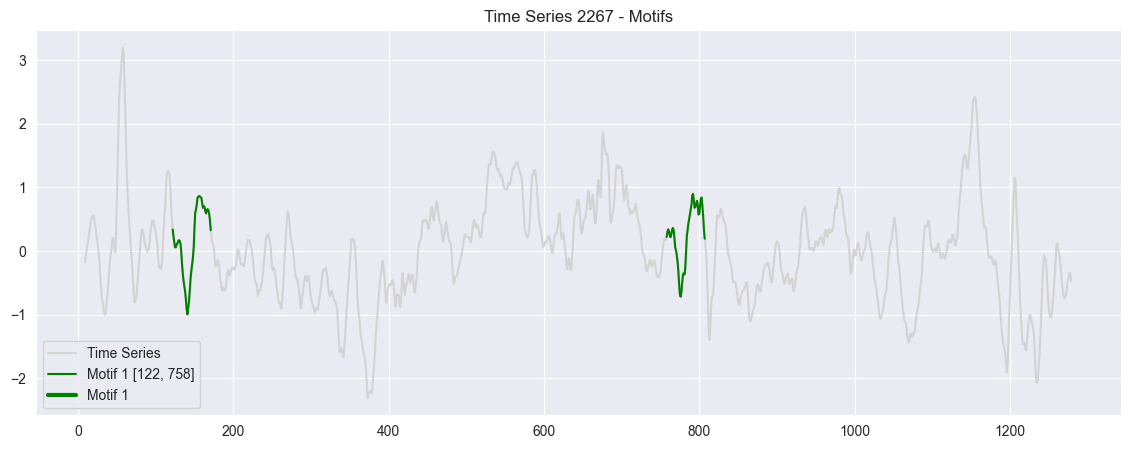

5jWwB5TjbWbvOWczYfUJ28
honky-tonk


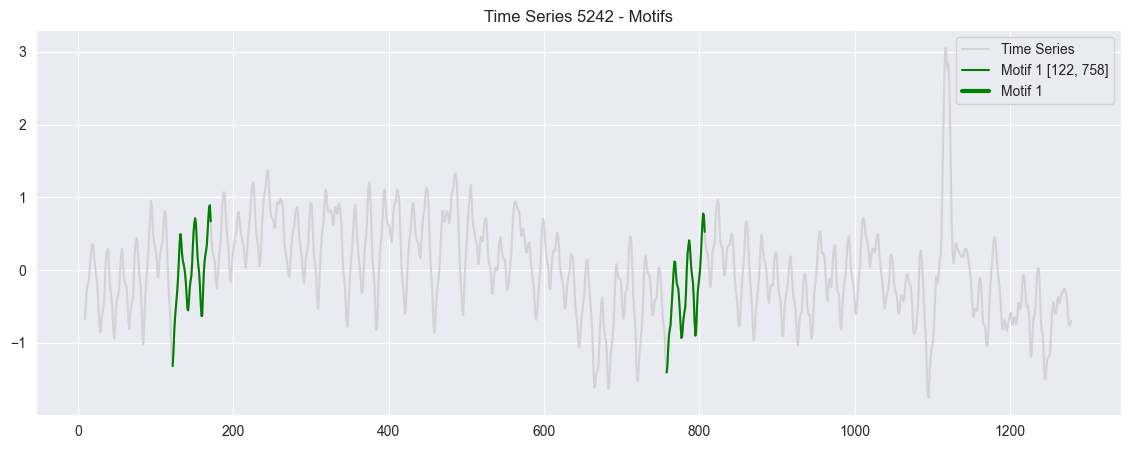

1RZ7TBM8Q77L44fC1f97qU
sertanejo


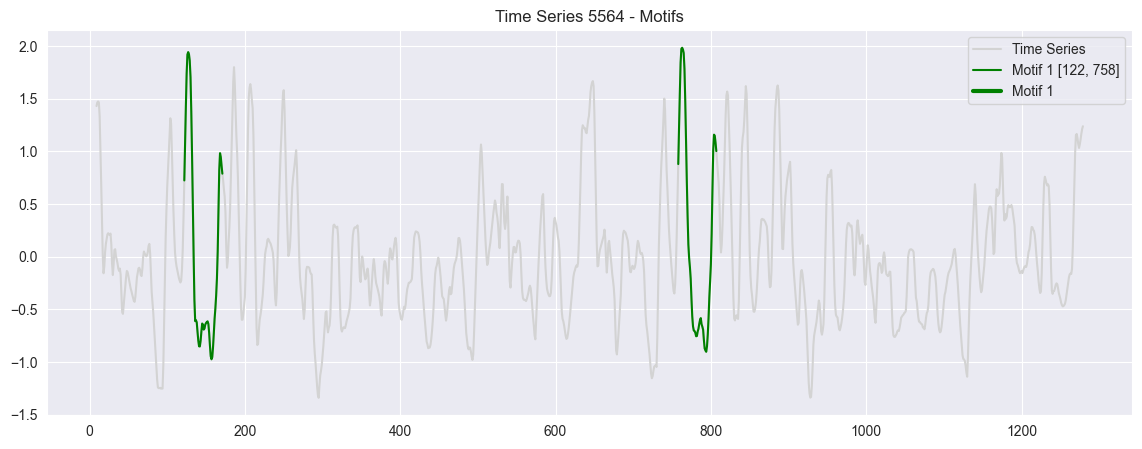

4T3SkqoVATAGpizjUyrMzE
folk


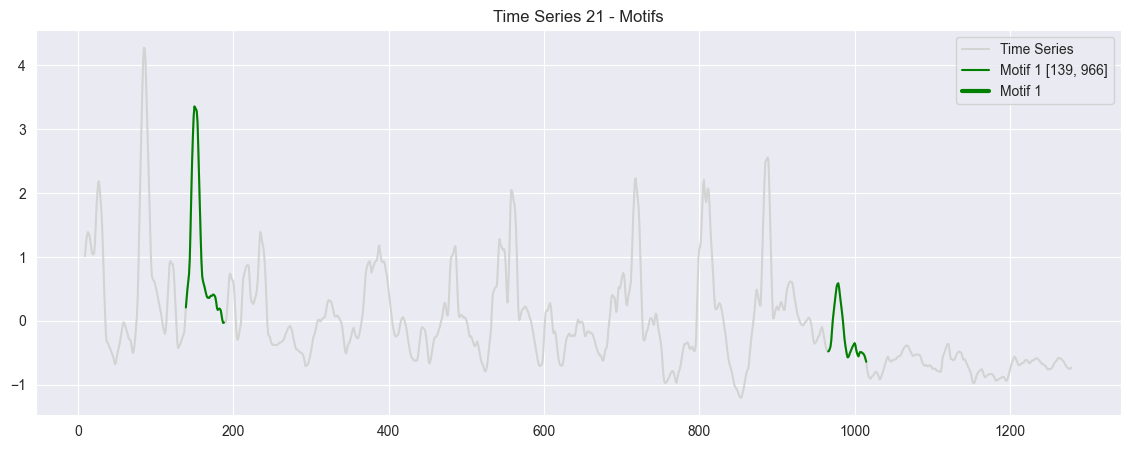

62ODcIMTYy3Ccn7W02gf4w
mpb


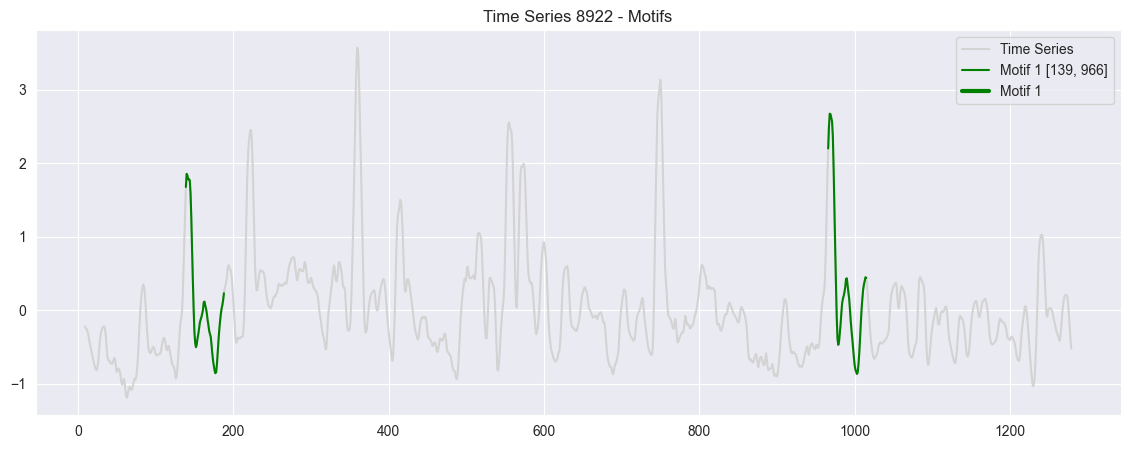

0HuS5vFQd06cXV54I0twkV
songwriter


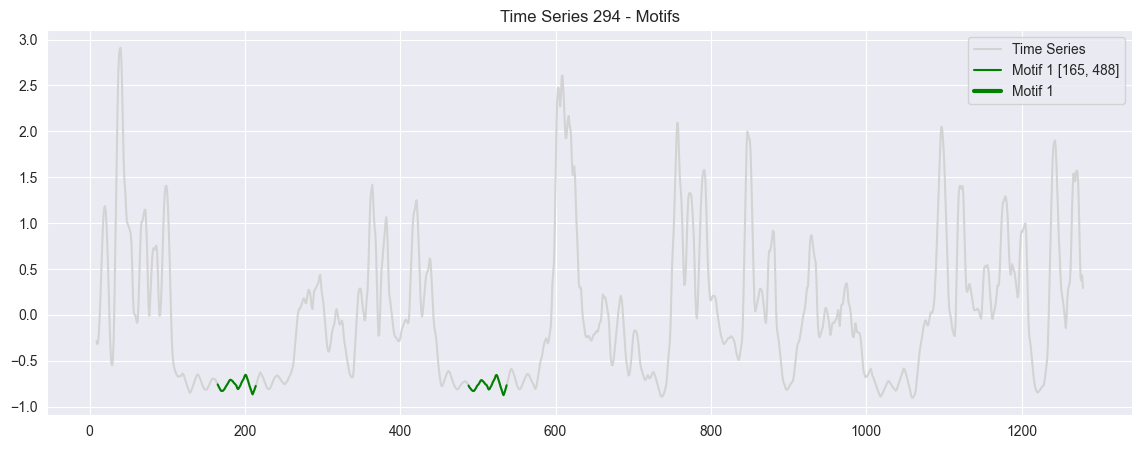

3b0cJPguhWOh2hjY6Lu192
progressive-house


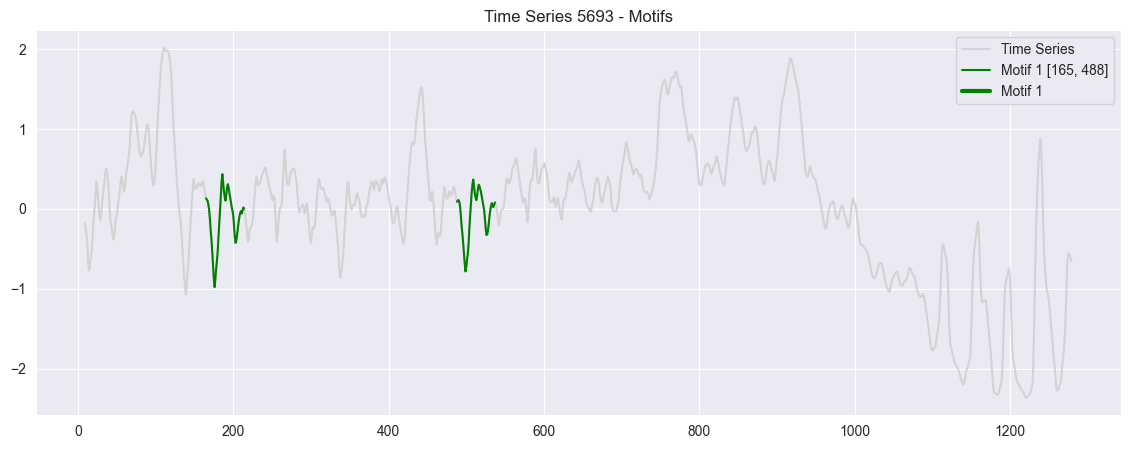

4TntitqQYWyRoIc7WuvESy
new-age


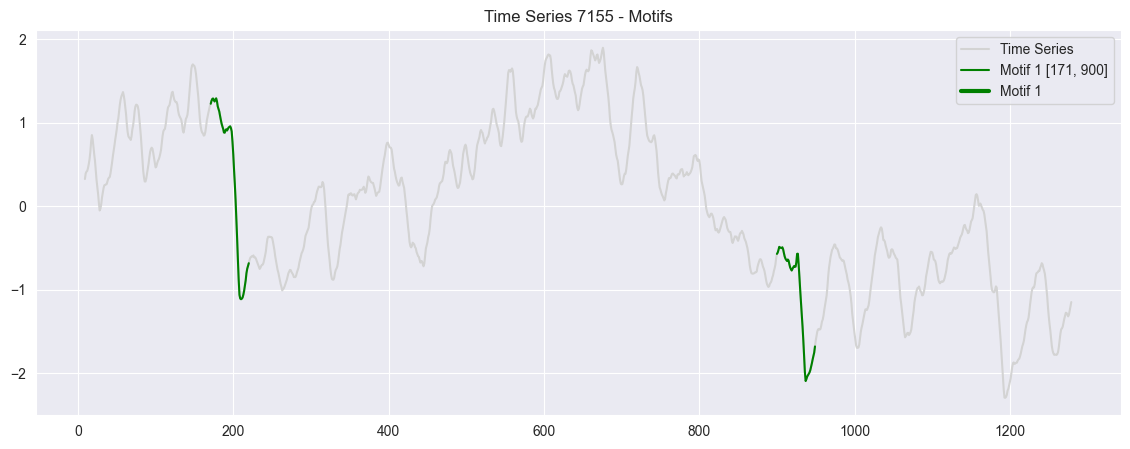

7wBZPN1VX5V1RaUK2v7TlE
heavy-metal


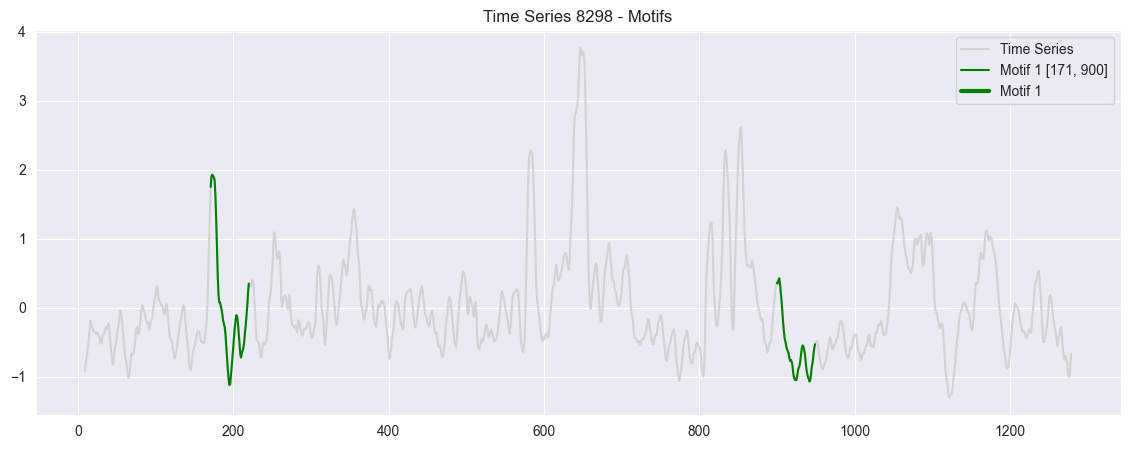

0RT86wBrufYQZSdN852Wjn
songwriter


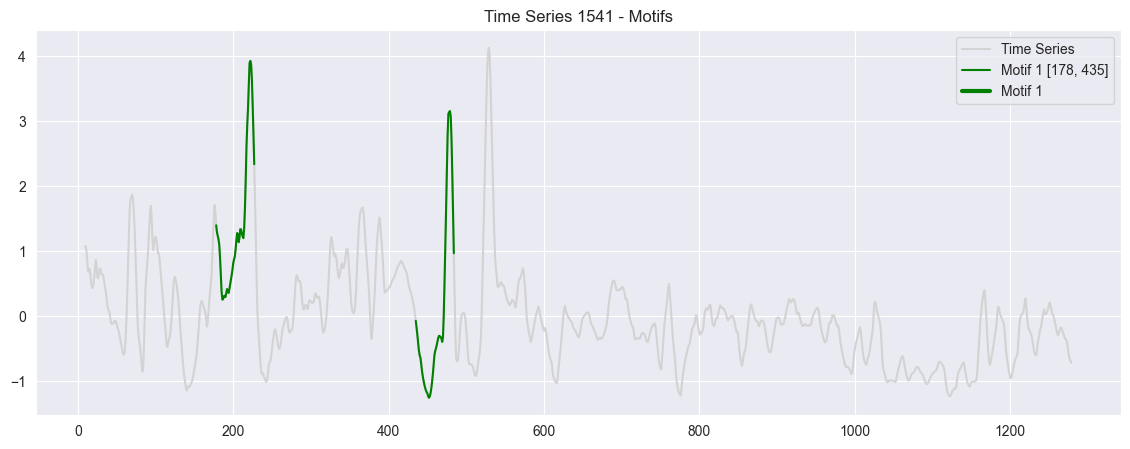

3kIRcIlADxLmvzkiqXnBbt
goth


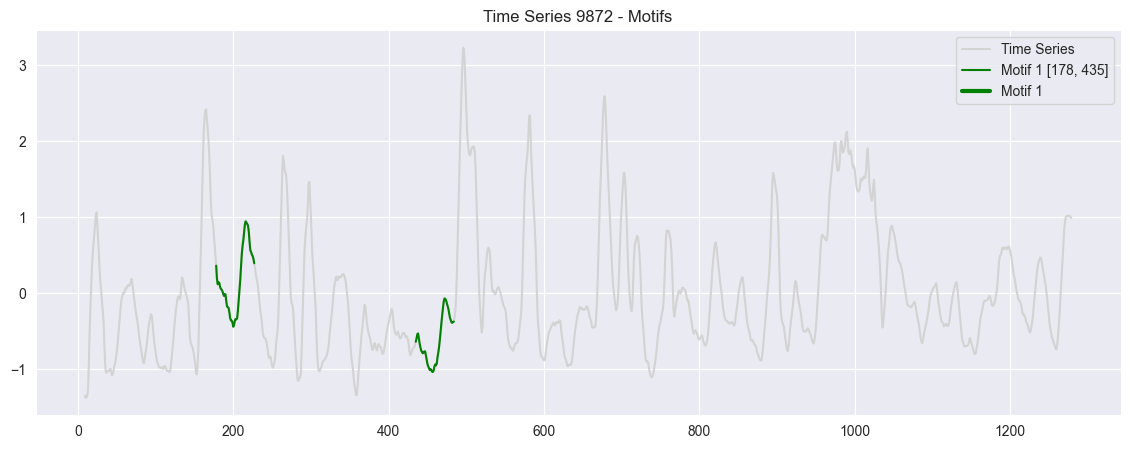

7wxeGWvf8HNuUeK4k06mOr
progressive-house


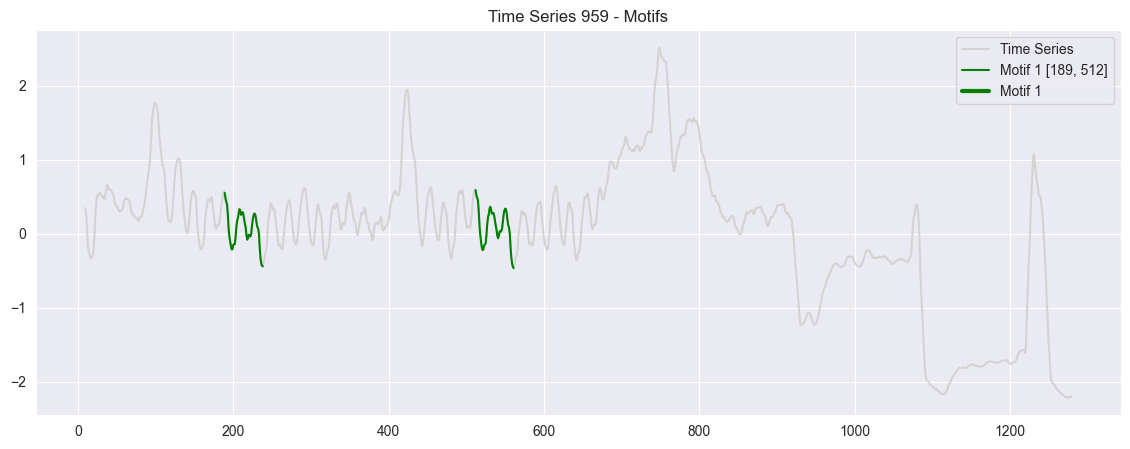

1UfULERSmyWGgbiHbUIjDB
goth


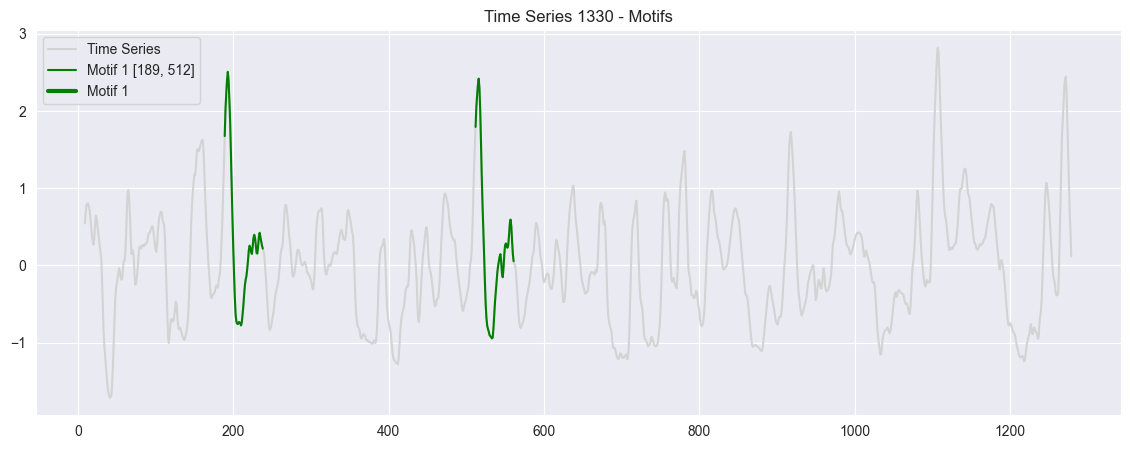

6skTPlJtkpqN7mM95QfsUD
minimal-techno


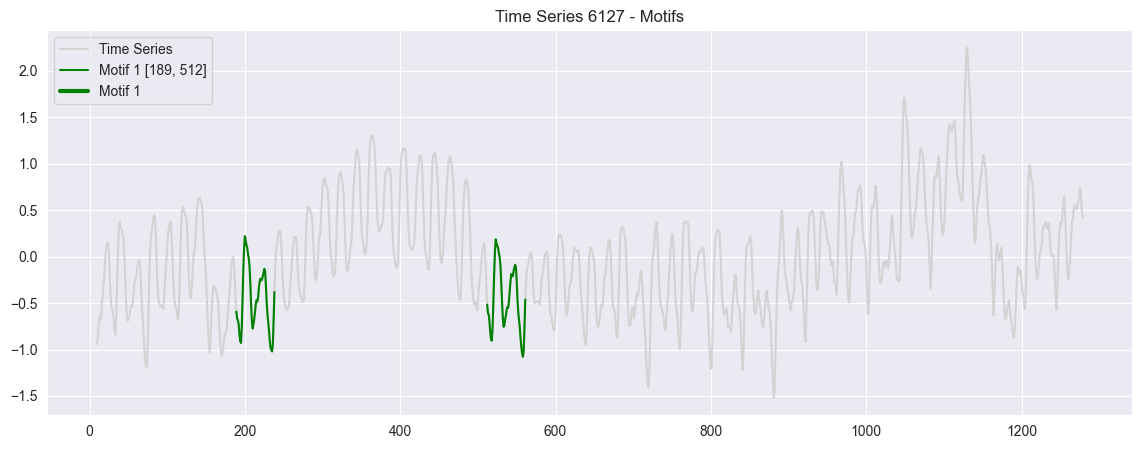

0RsOUnm1wNpbXxZ8a4abOP
goth


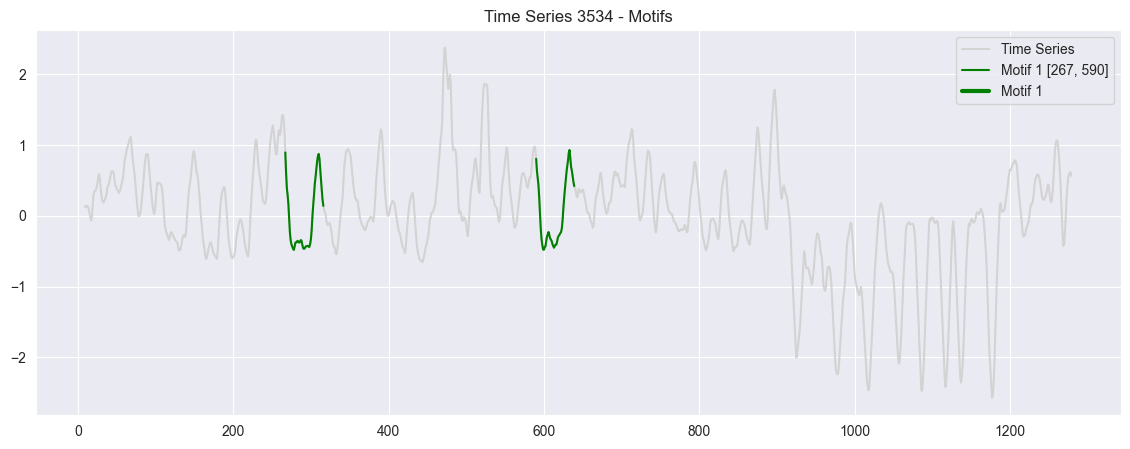

7f6YYO3XtJgWiddeVqnhI0
piano


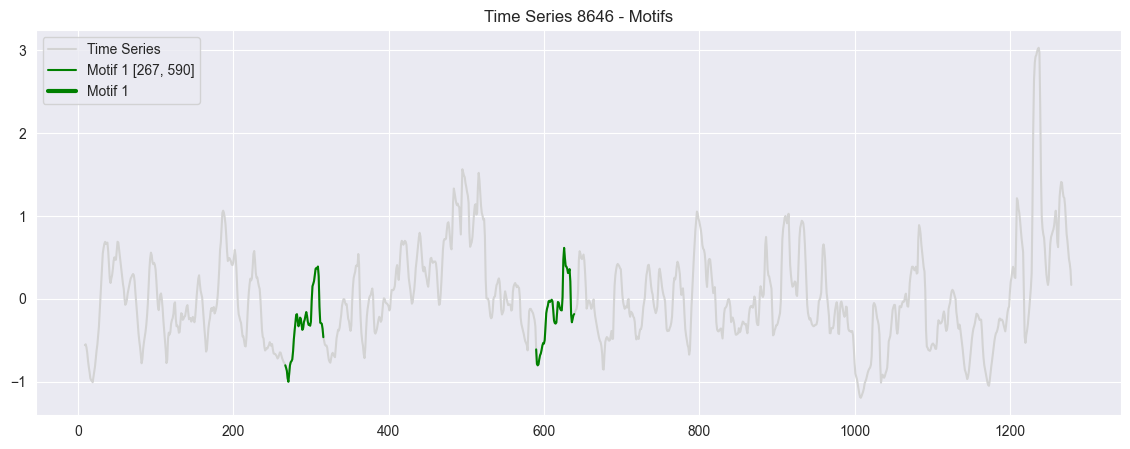

1ROhZEUOmH3tsgABG4LqAY
synth-pop


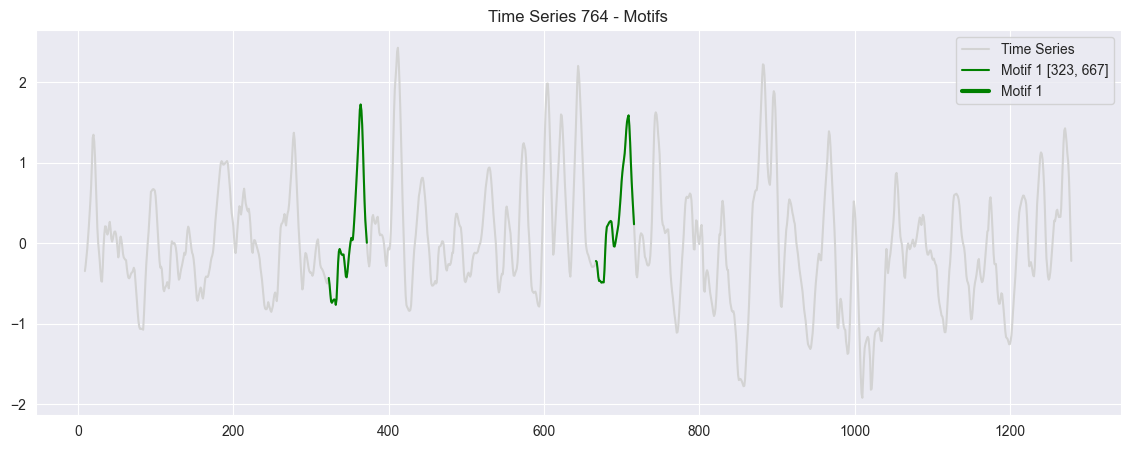

5P11YP7mL0gOK0VGCY65Vd
goth


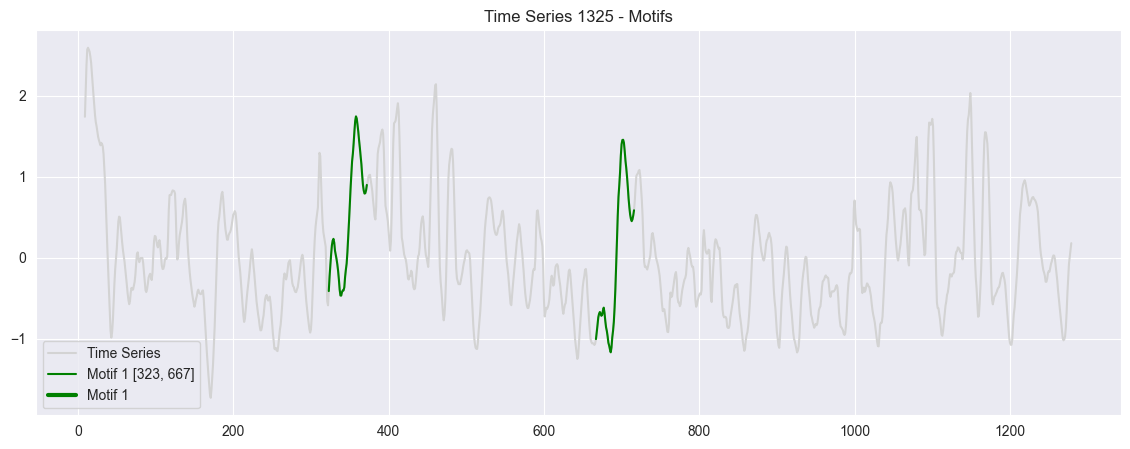

2xADGxc3wNQk9YBSWIROyx
sertanejo


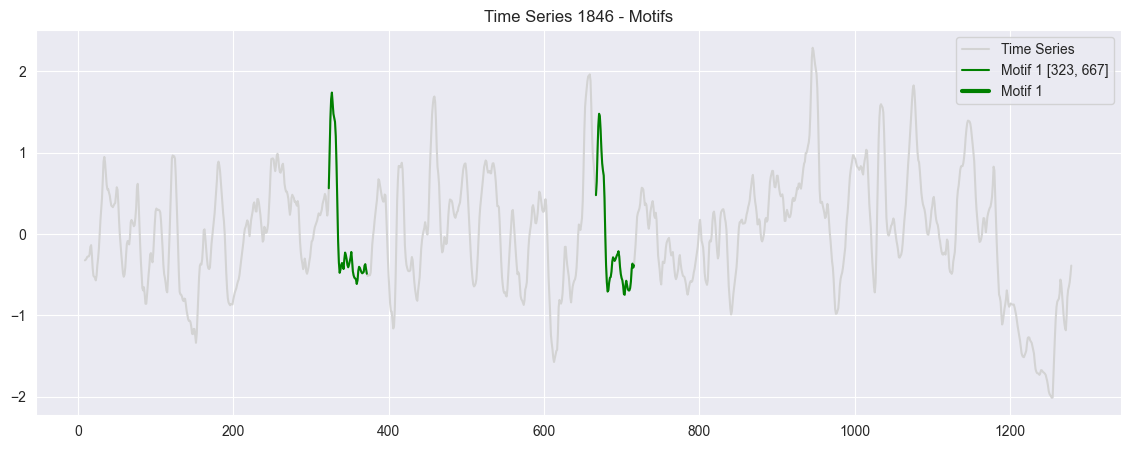

4FKLSypcBIVAwM2cyU0rjK
emo


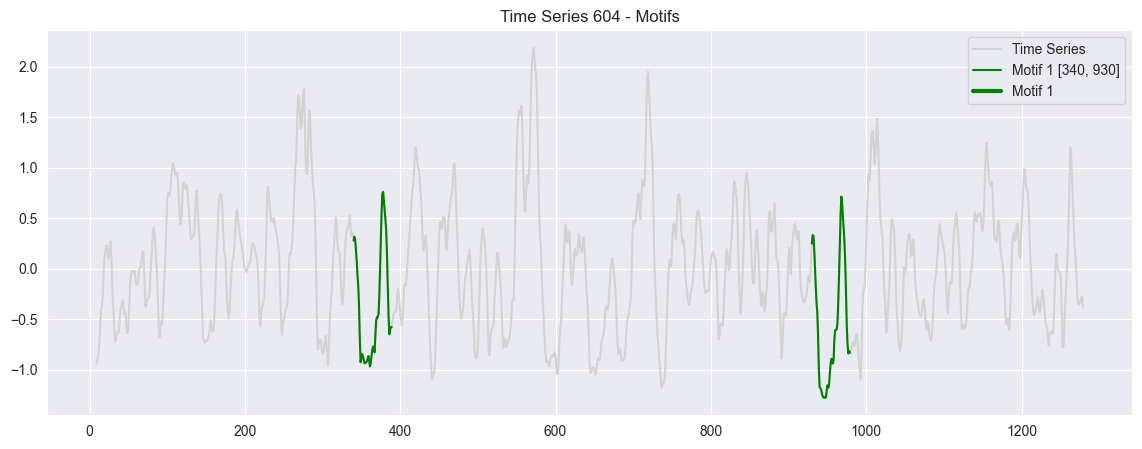

1e42ag8I6aNSeRd5vNGhLu
emo


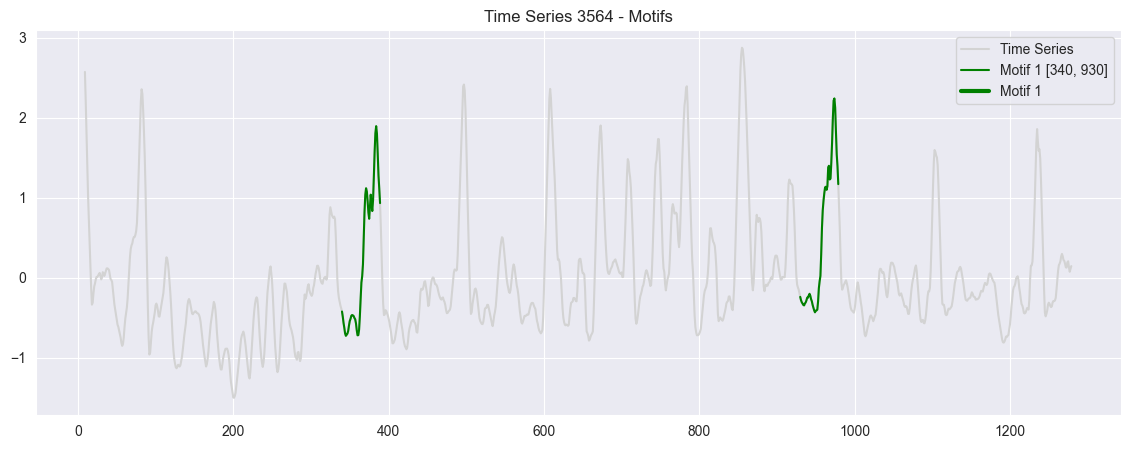

3HCzXf0lNpekSqsGBcGrCd
opera


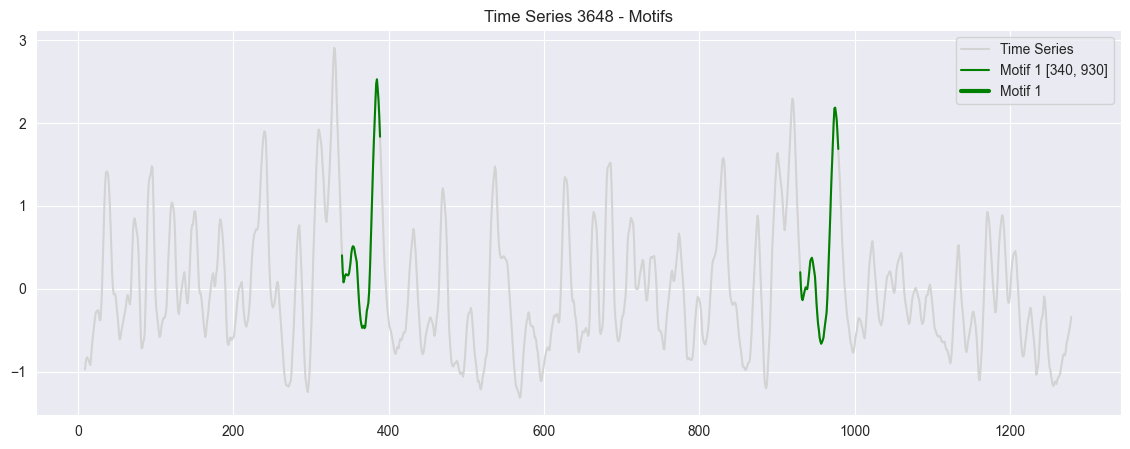

3dfyuF6ieekxpLW0di9Cfy
j-idol


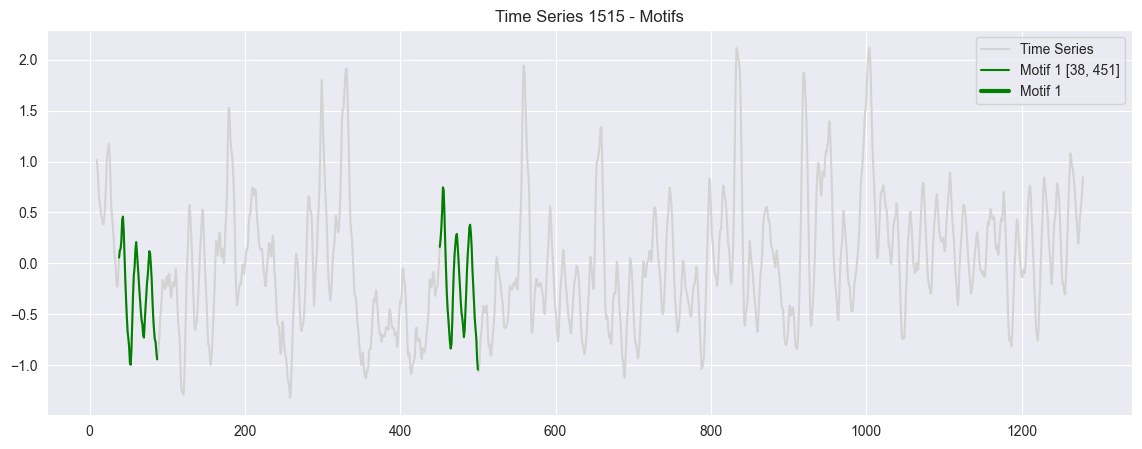

1I2I4x0SJcK6ccc6qvw76s
emo


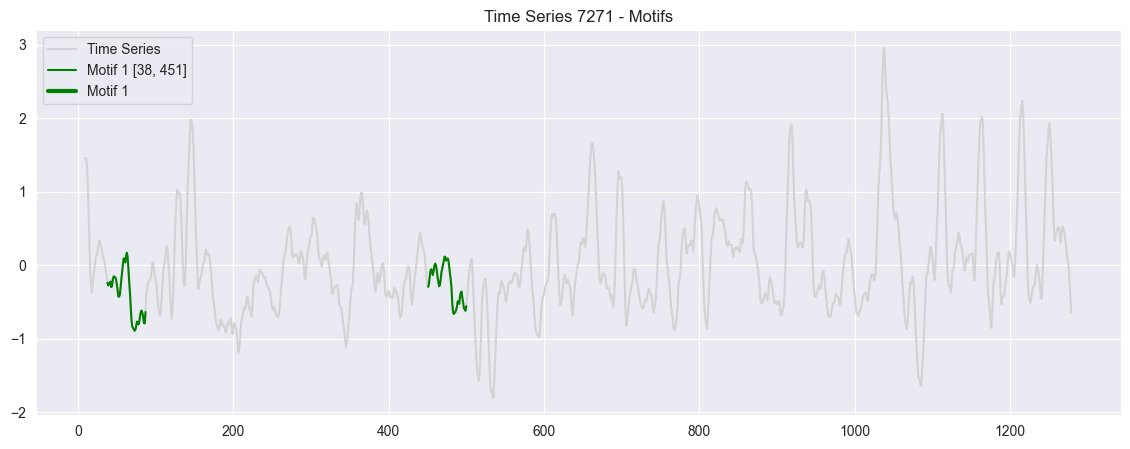

1sXBNgMWmm7TaP2oV6wKG9
j-idol


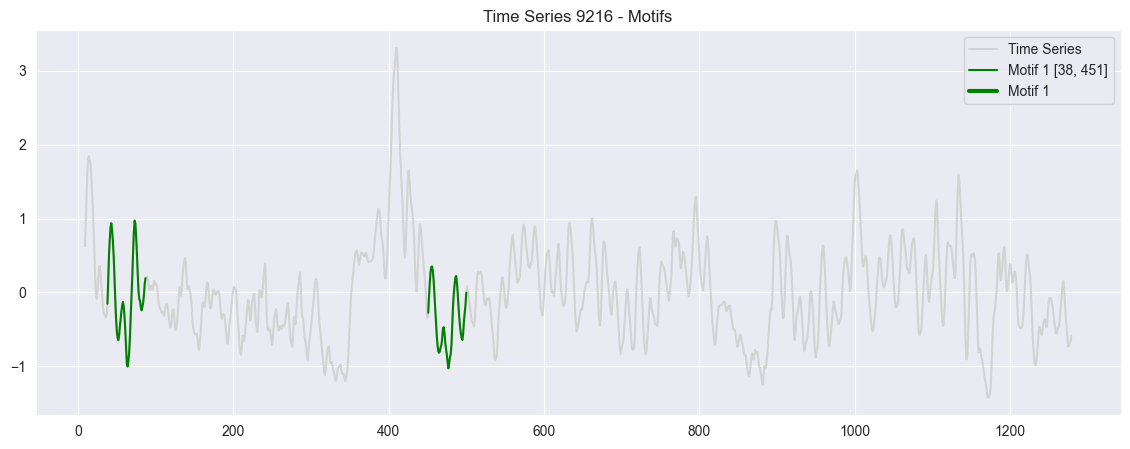

17w9YzwFHZH1BfzTDIRiw6
new-age


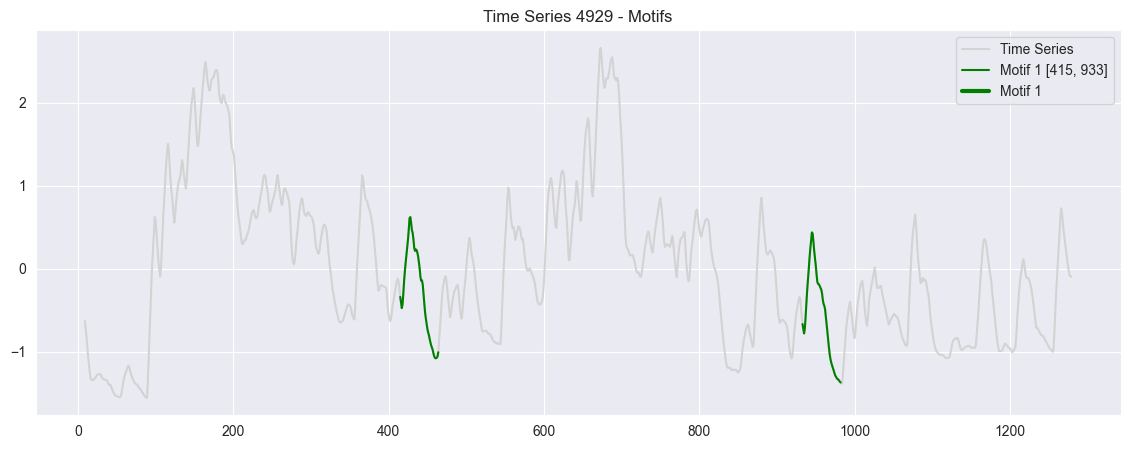

39lSeqnyjZJejRuaREfyLL
synth-pop


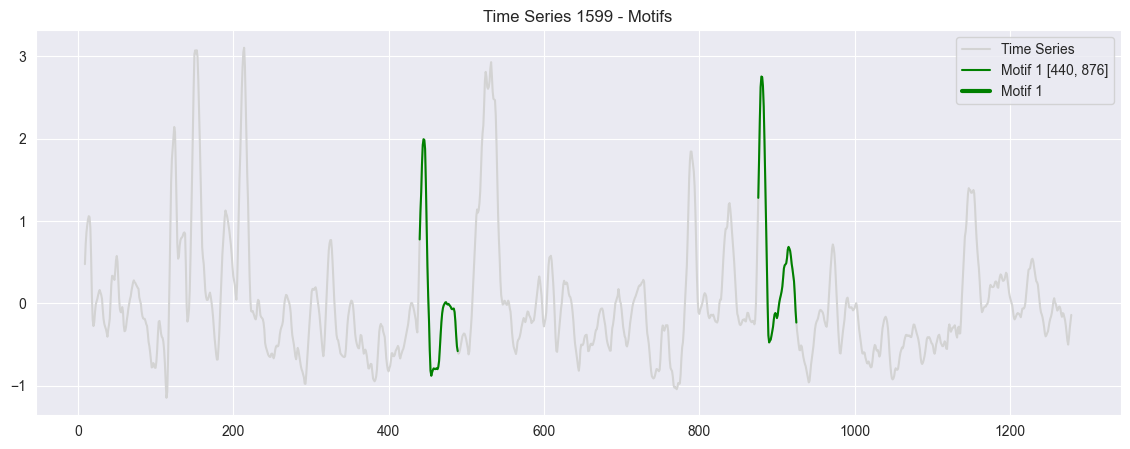

45oPsNIWxMG0K8KJGKSCdA
synth-pop


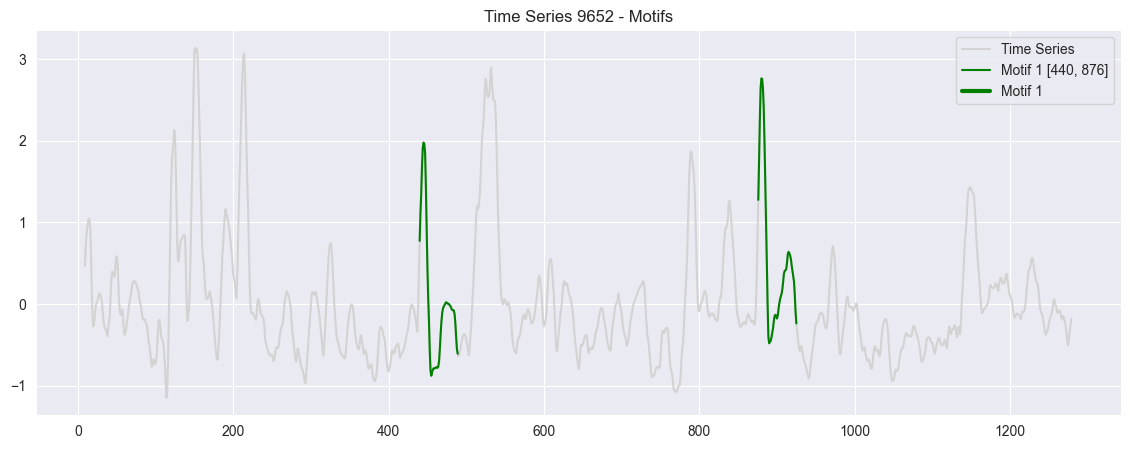

0udvqTPCimWmF6eXn93ZL6
new-age


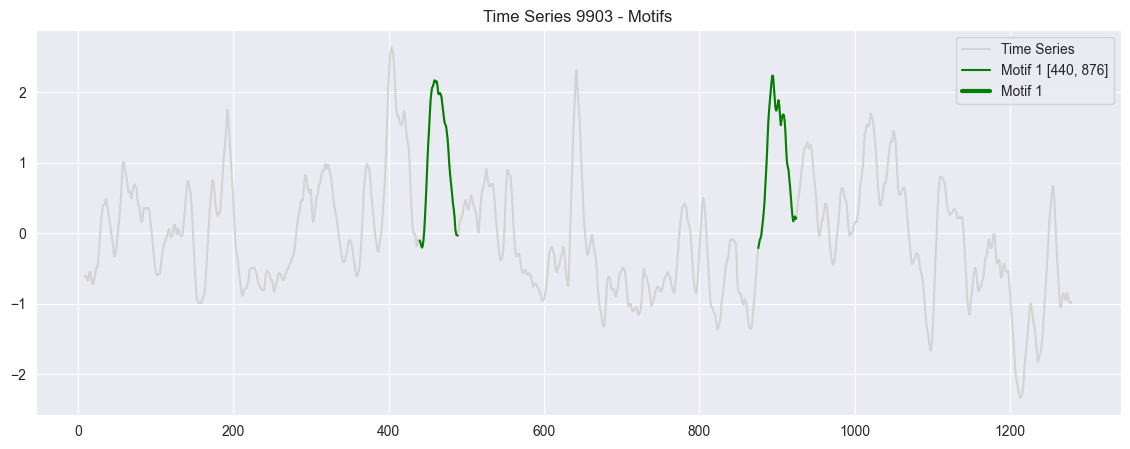

55YClWYJCtrXLc6bOgeVGZ
minimal-techno


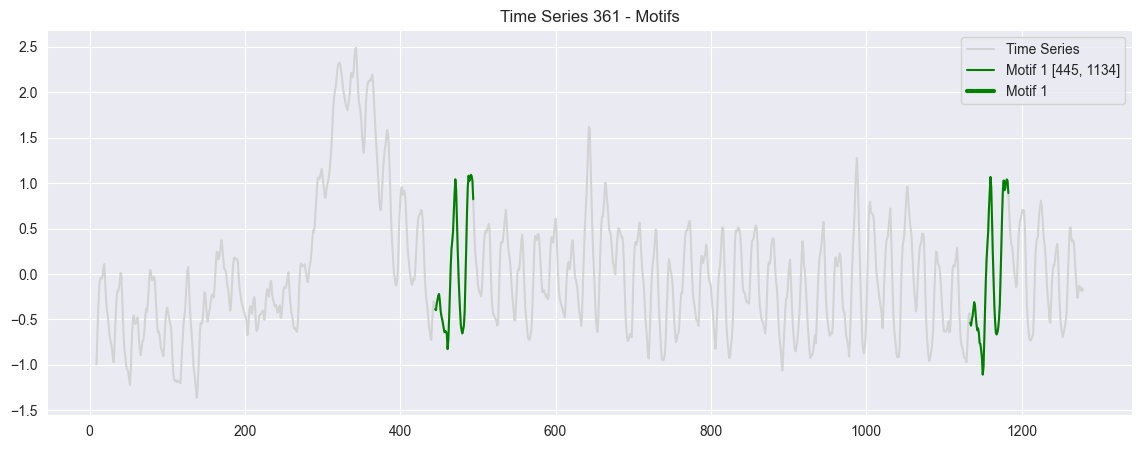

2OfE89ODPyOb3jVpW8DDJs
new-age


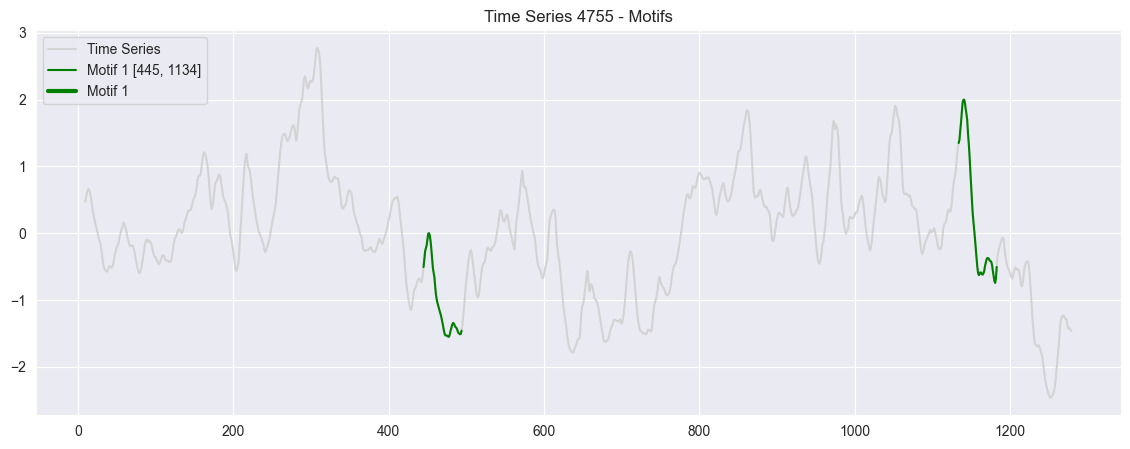

4e6fdJaczDlNjMvNwVMSVD
progressive-house


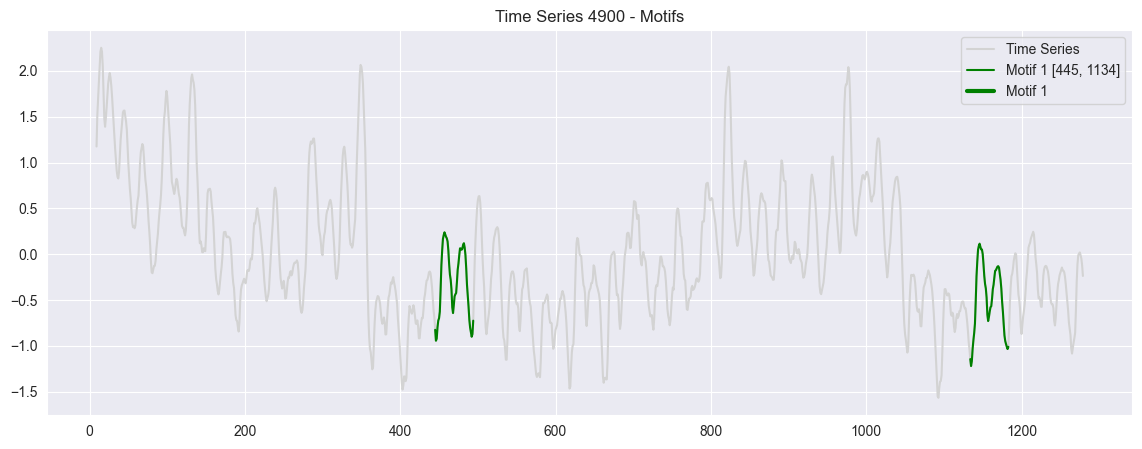

1ALF19nT37rRaJ9frQq35e
new-age


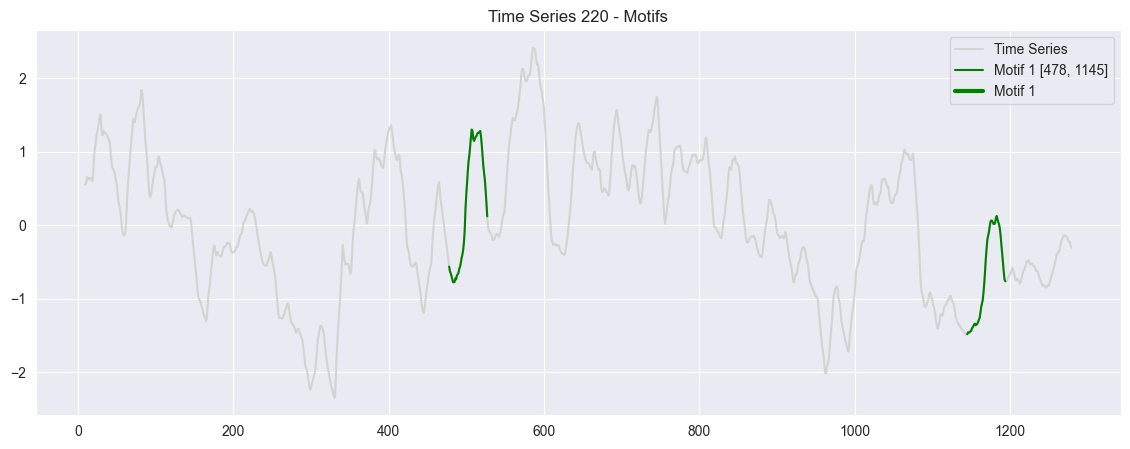

6YePT3fQZx7r1YauAnd3DP
minimal-techno


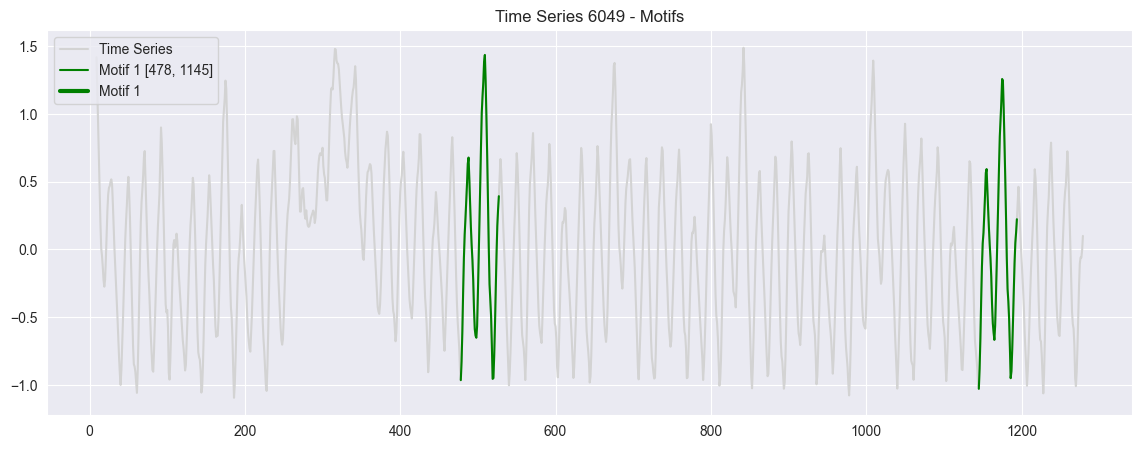

3J7P9d2U1MOvKlFsvPa2jx
salsa


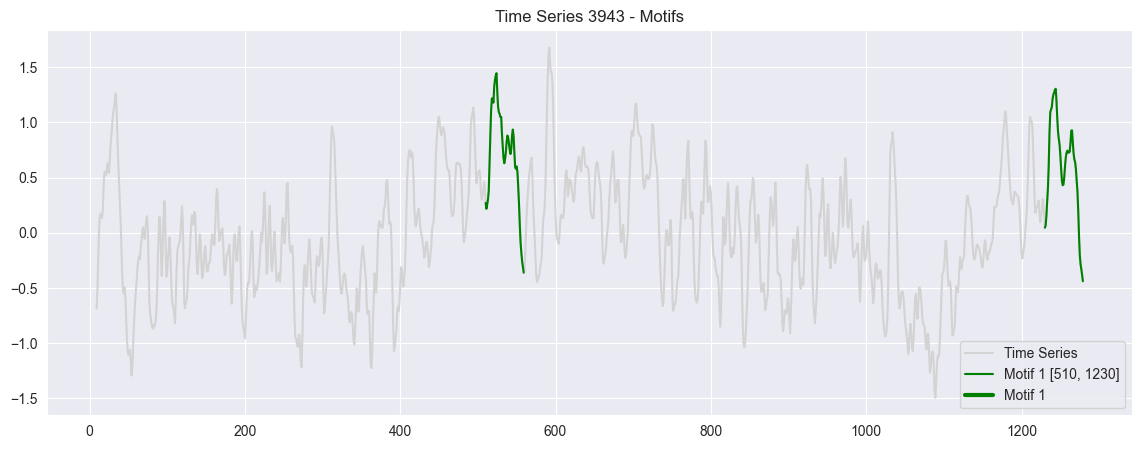

0VEyOWSkQ0yiYJiMxzAkS8
goth


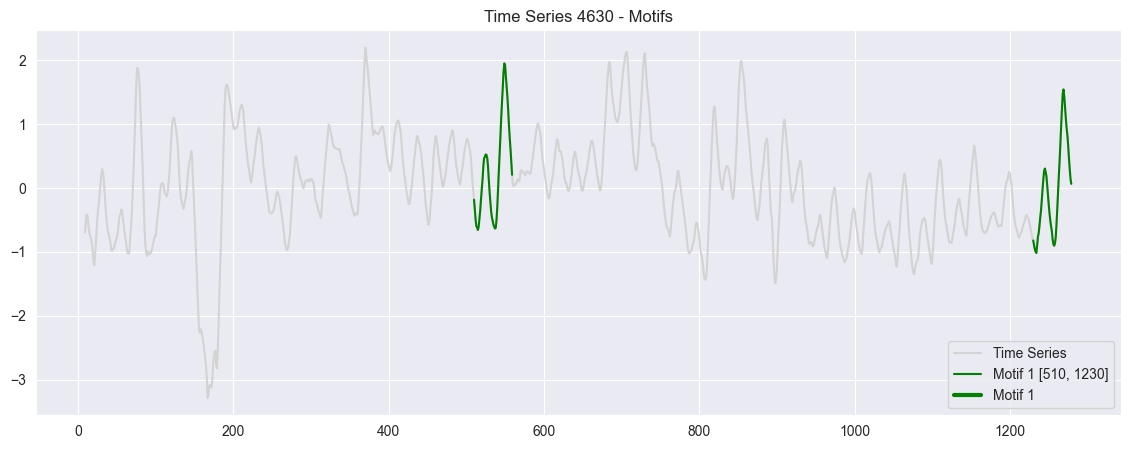

6Z8sv0vpi9I8yYanAJWz3v
heavy-metal


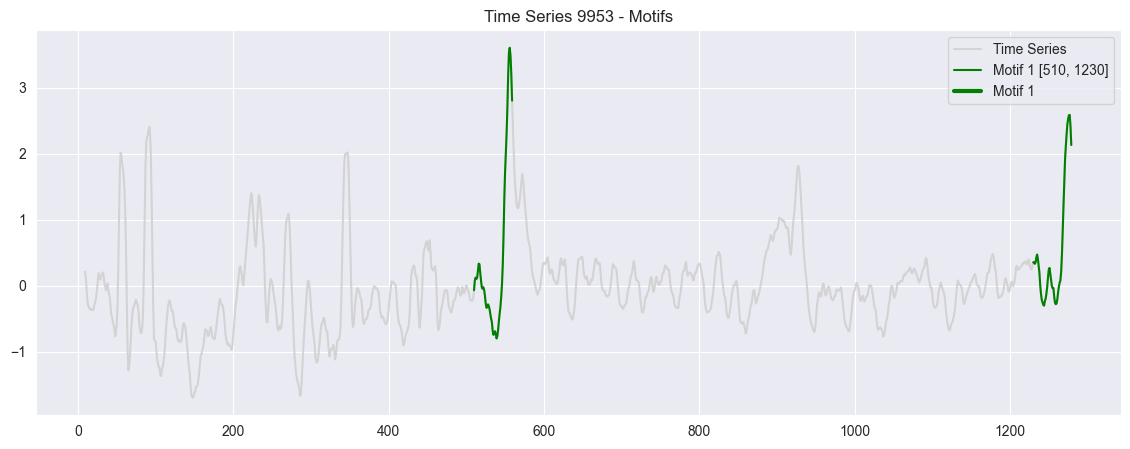

3JfO7tK6i0HObI0mOOg2un
sleep


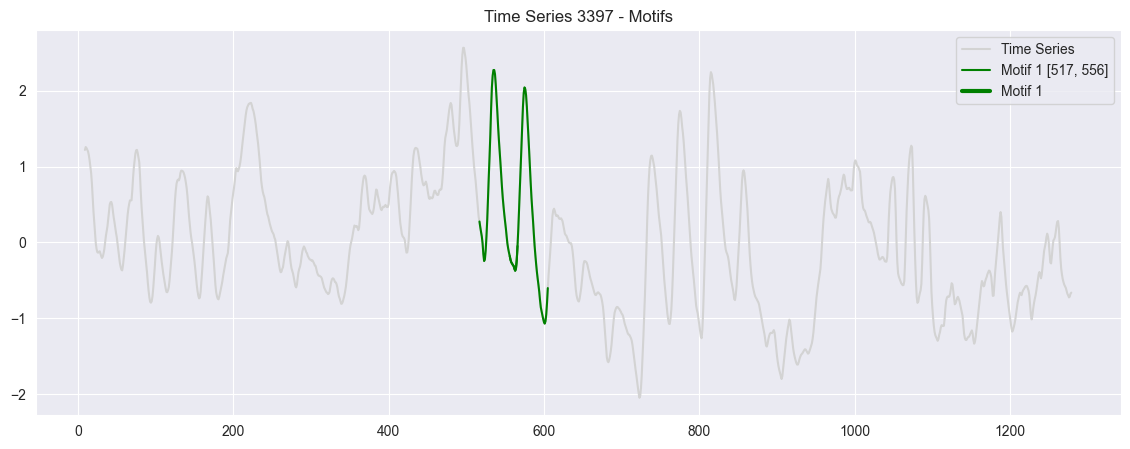

2oVIceKK4OhBqcWMsUDIeF
folk


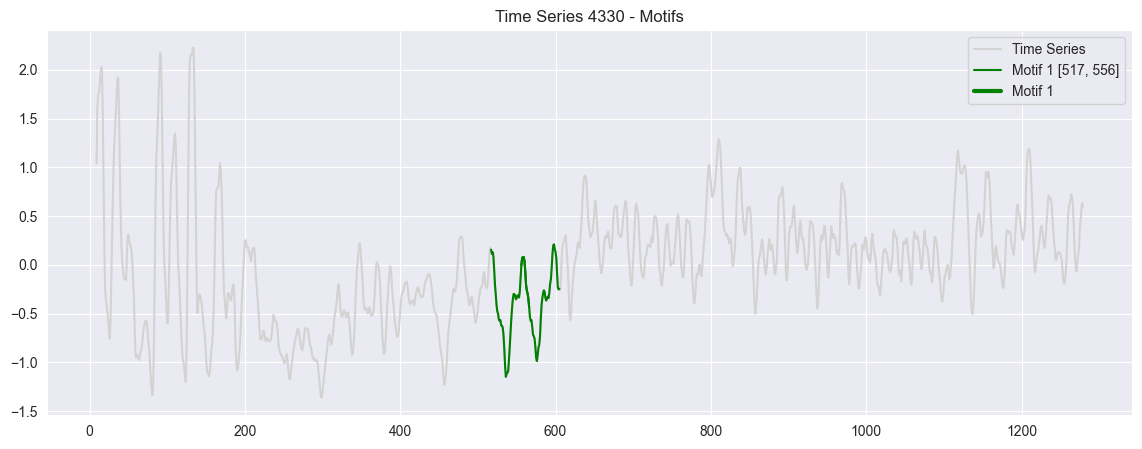

1ZwyRRW5zGjt9gGOwSO5YM
world-music


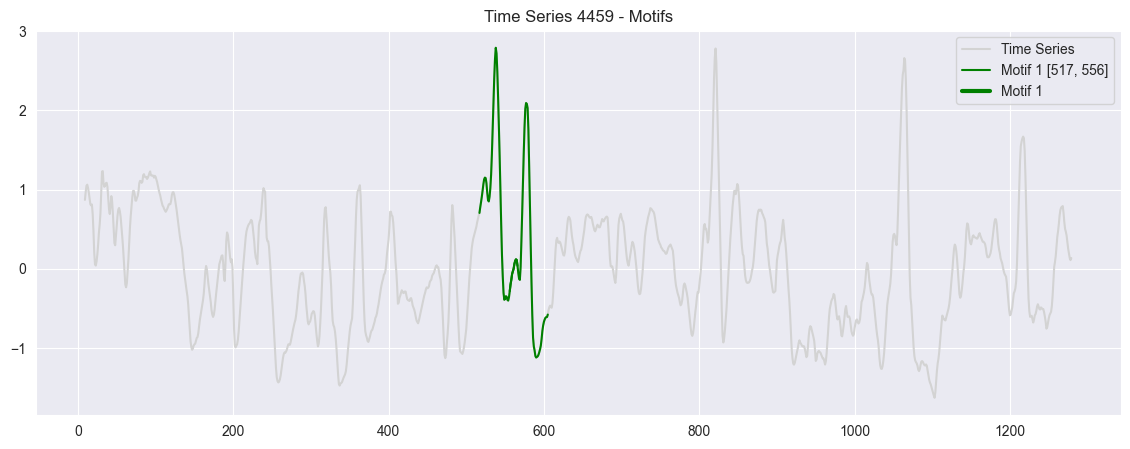

3AhXZa8sUQht0UEdBJgpGc
folk


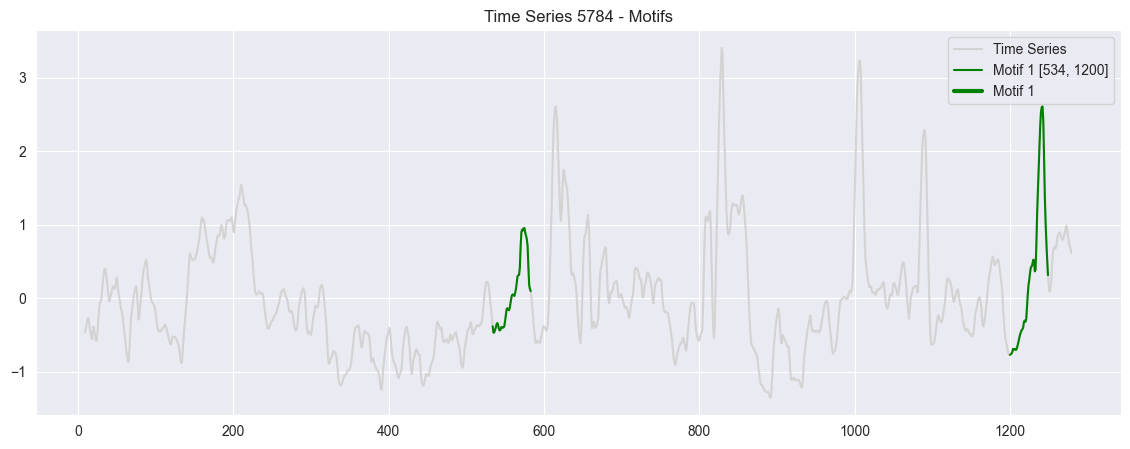

1QCvMF4Hq88nA36Rek7y05
emo


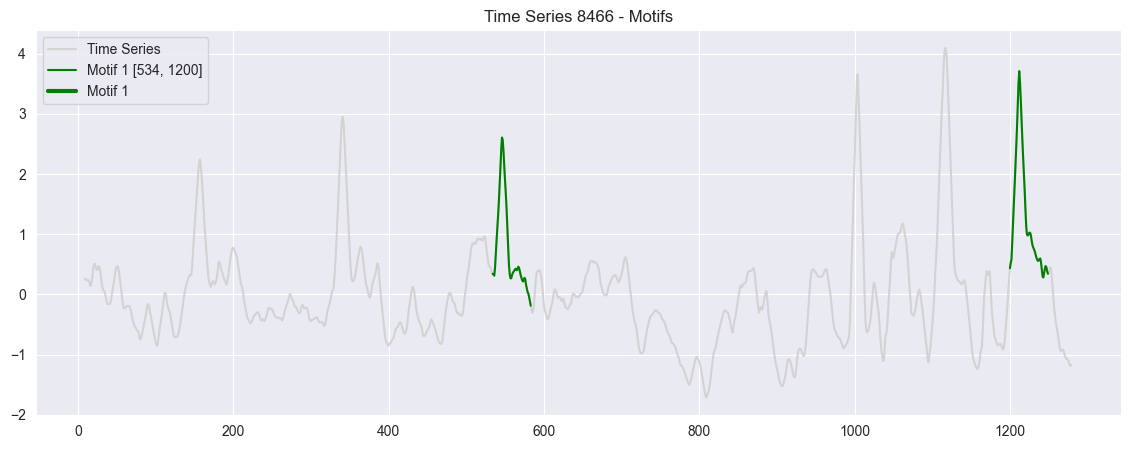

79dlXRI1RrGJfv9TGOBEOv
minimal-techno


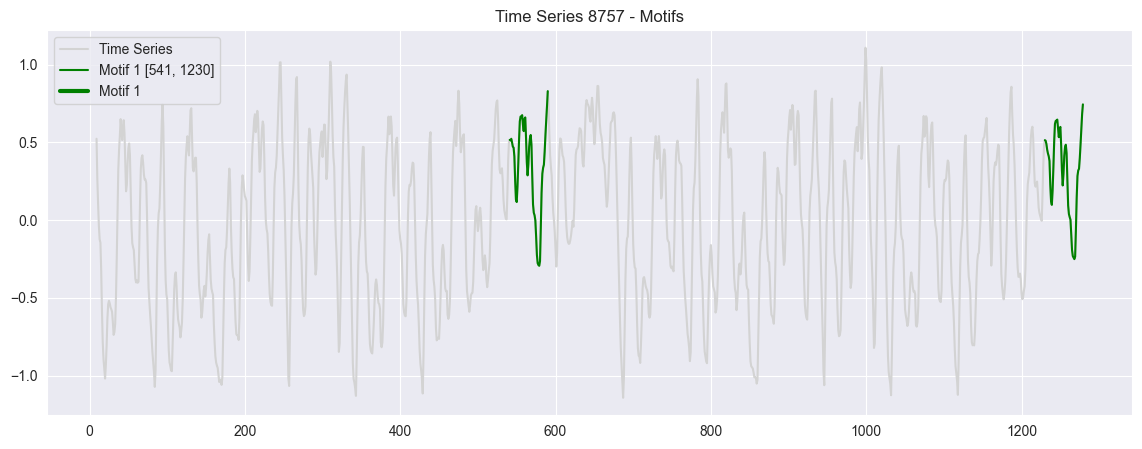

2V1UjIW8DUV9jzpcOffRXk
emo


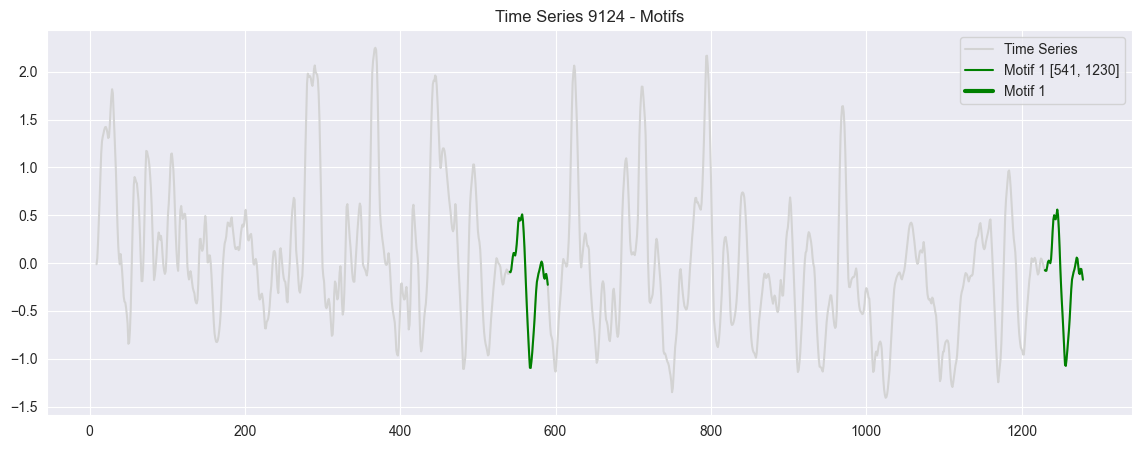

6dwR06Edc87fGq9vpSBBtJ
minimal-techno


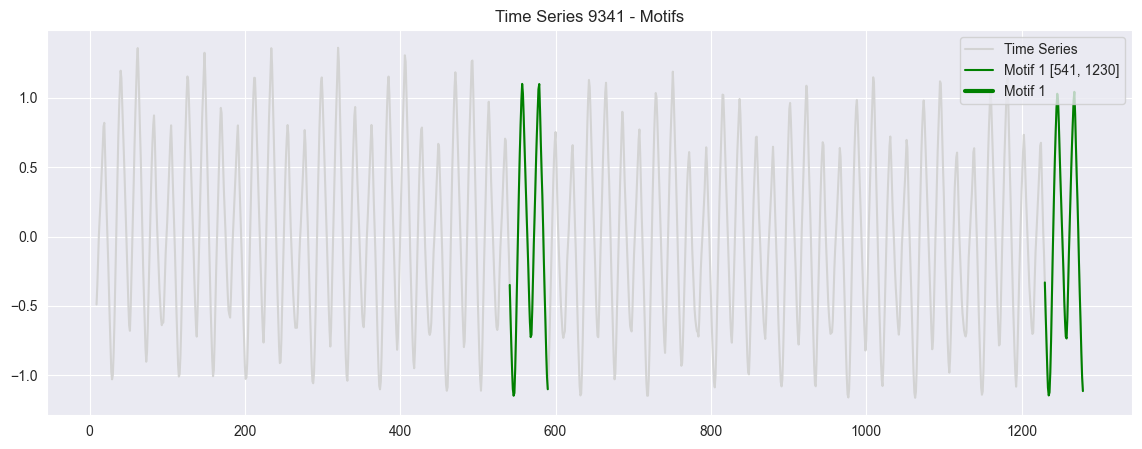

4LB6NIm3jSCxyTM4eyNJJA
new-age


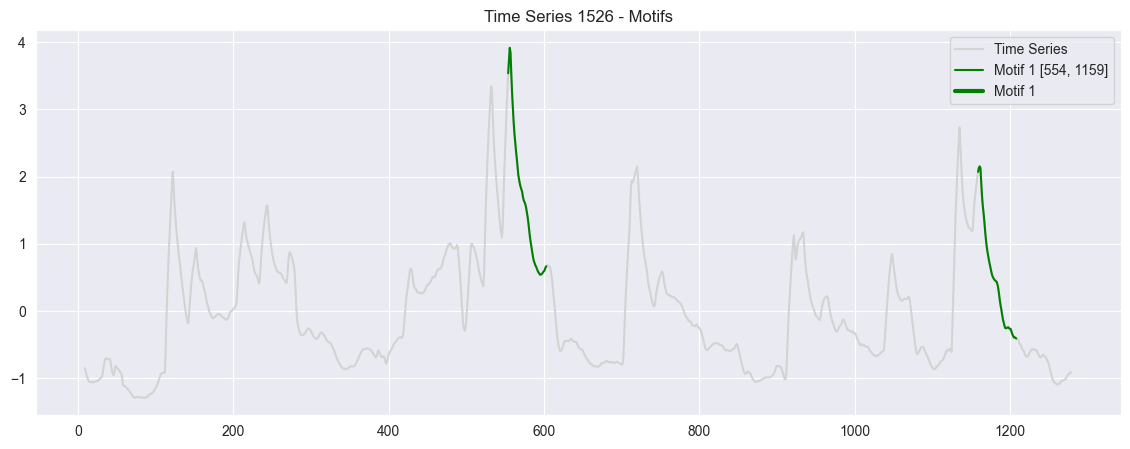

03dRFCBePUxmKYrL9im8v0
world-music


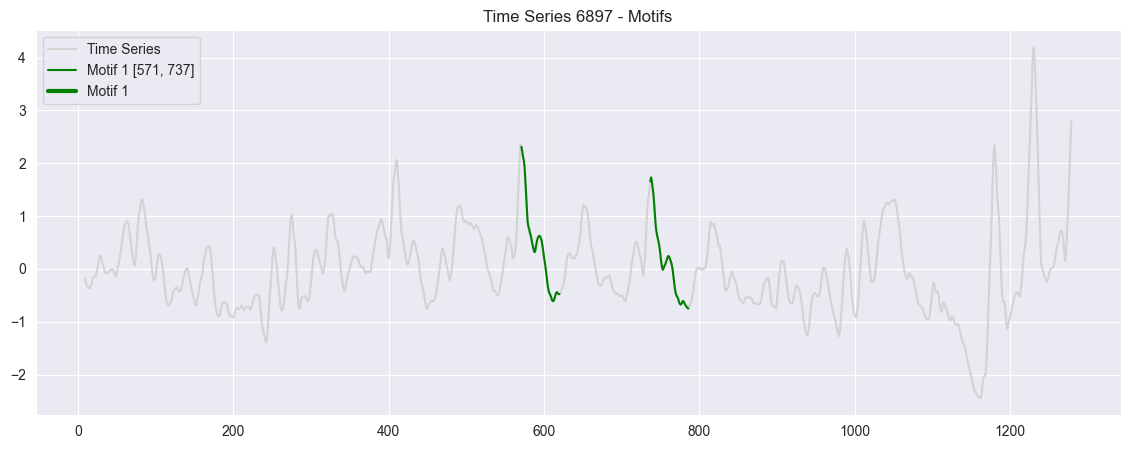

6I9RdlRSBF3NNcwZ9eNXaV
progressive-house


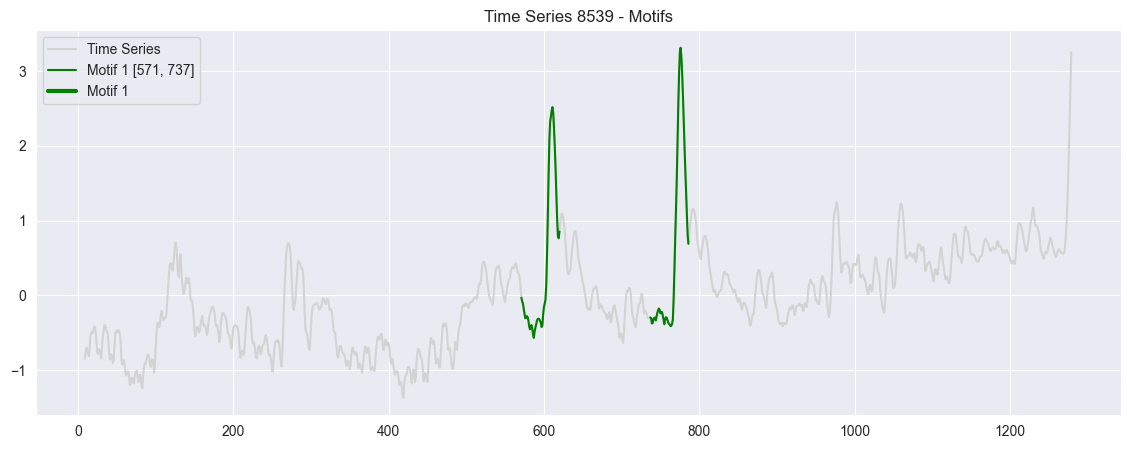

06p76VeZ5hze6B575qxlXz
world-music


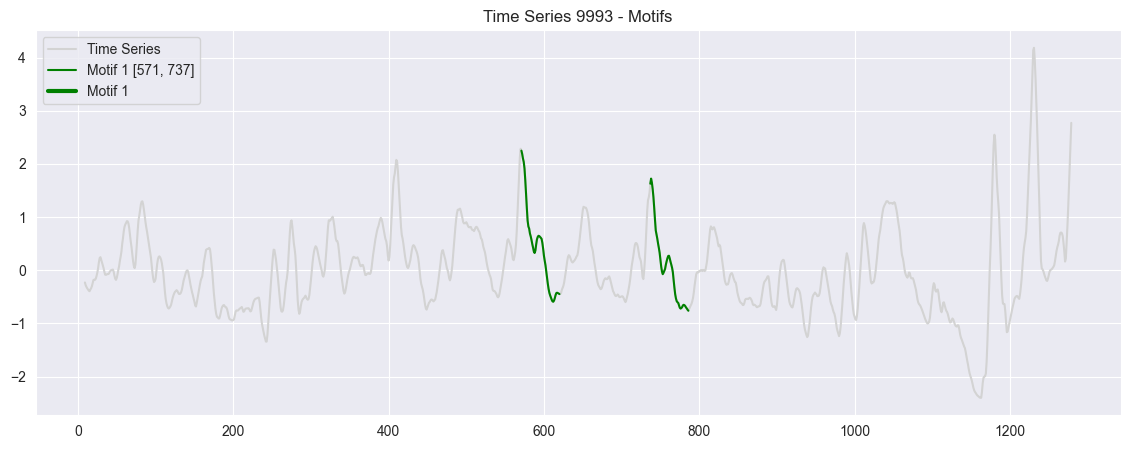

5JbPjRk4CJCPWJPQ6SQO6K
new-age


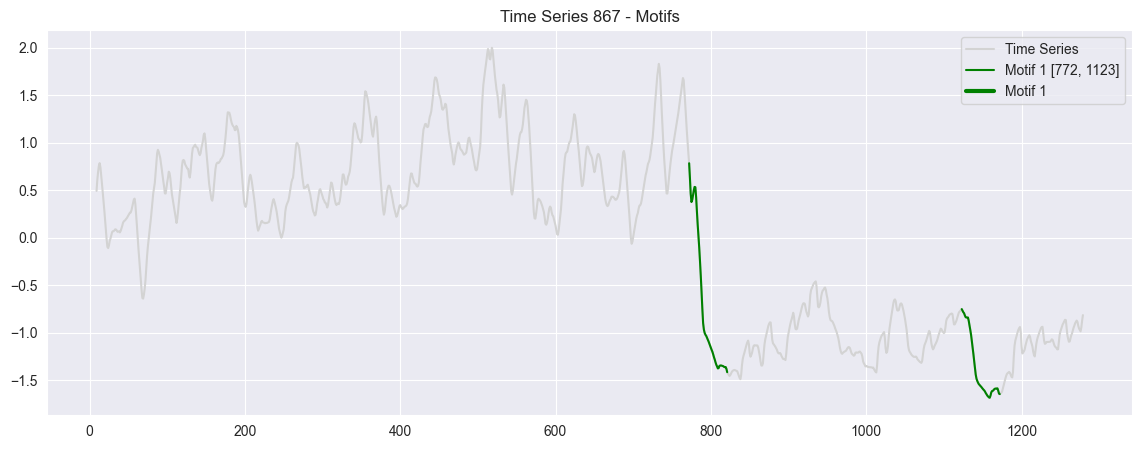

3tjD7HzGQHro2XYQybZd0z
new-age


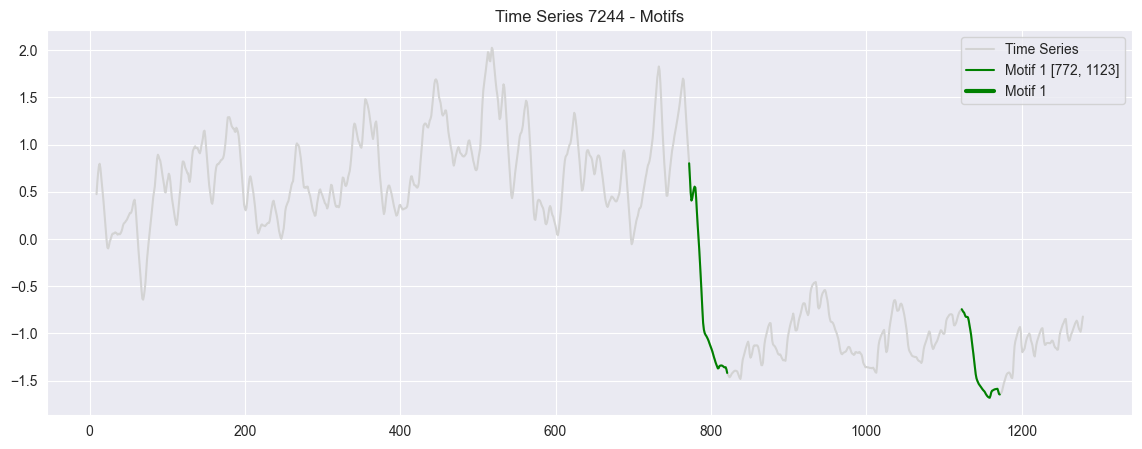

643KA1xhBJCulImSKjxSBN
progressive-house


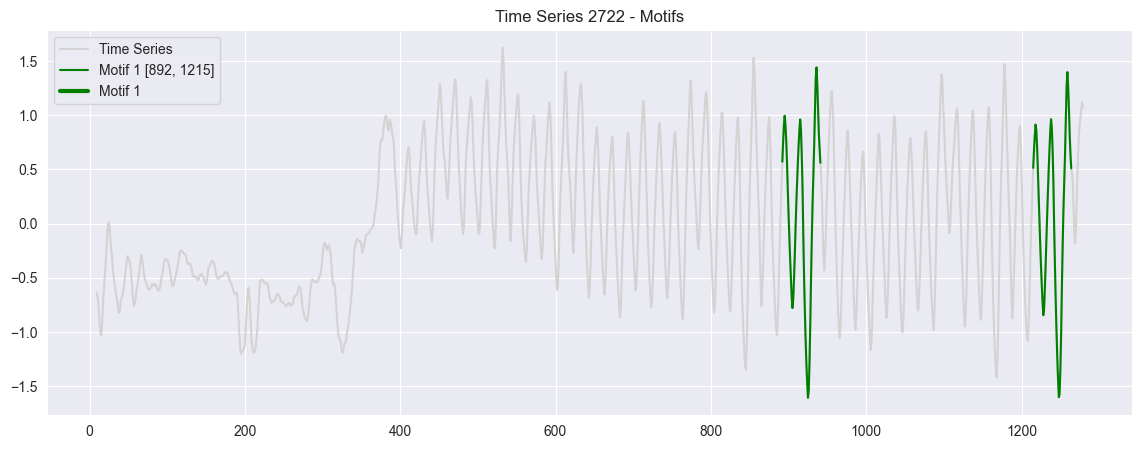

5Uo7AAr2d1CNZlaKgVUT3i
synth-pop


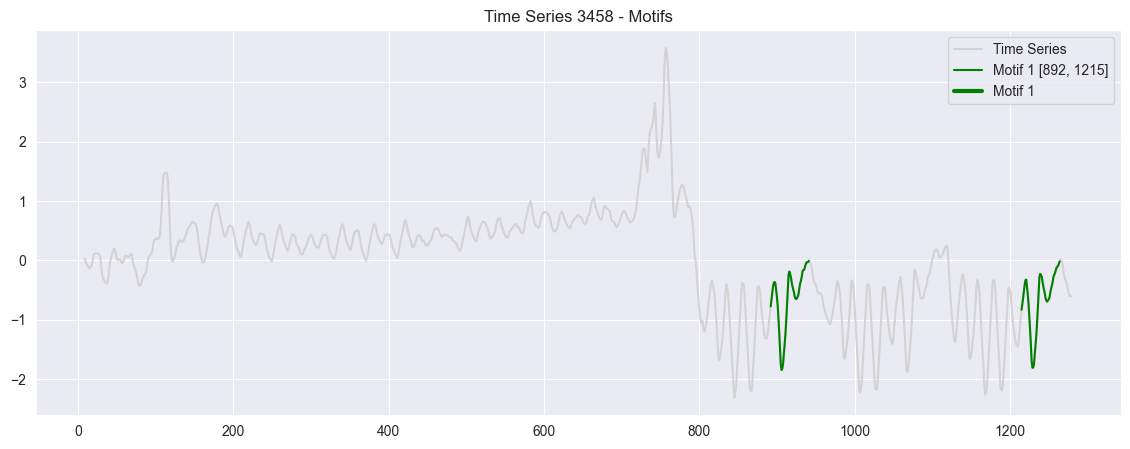

2TZtQt10Ajm3wB4MoqluZj
heavy-metal


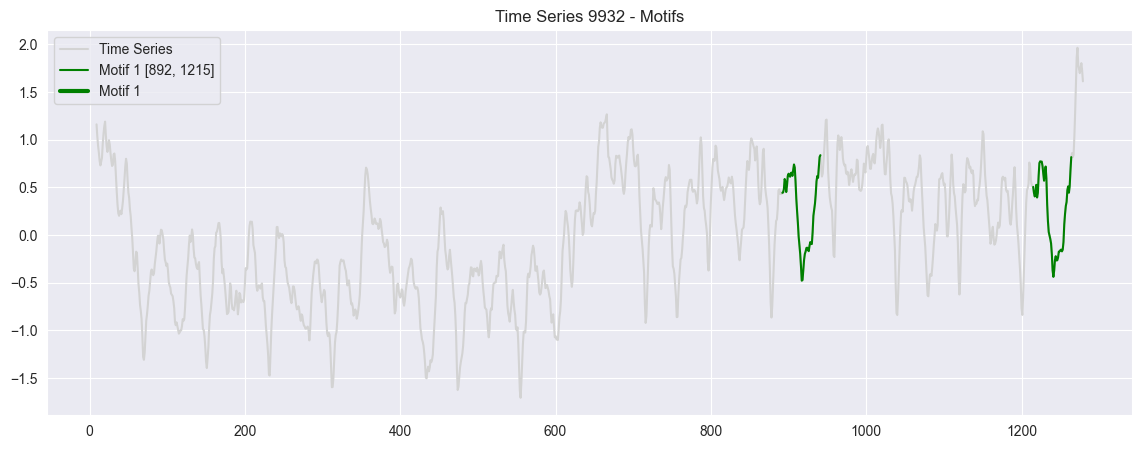

33vHQJWSTGFGl2SXMBkxvO
emo


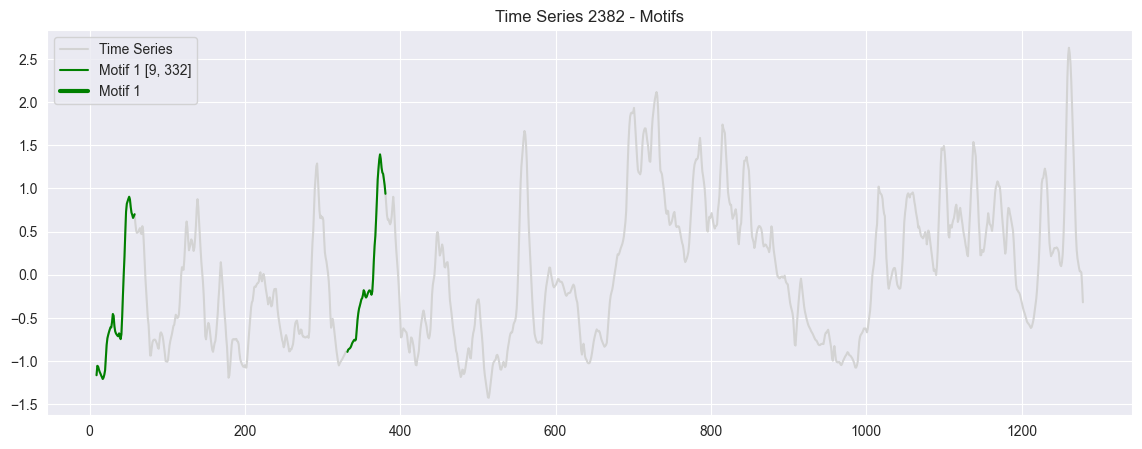

7k8Rj61mspwBrNEo6HEX05
progressive-house


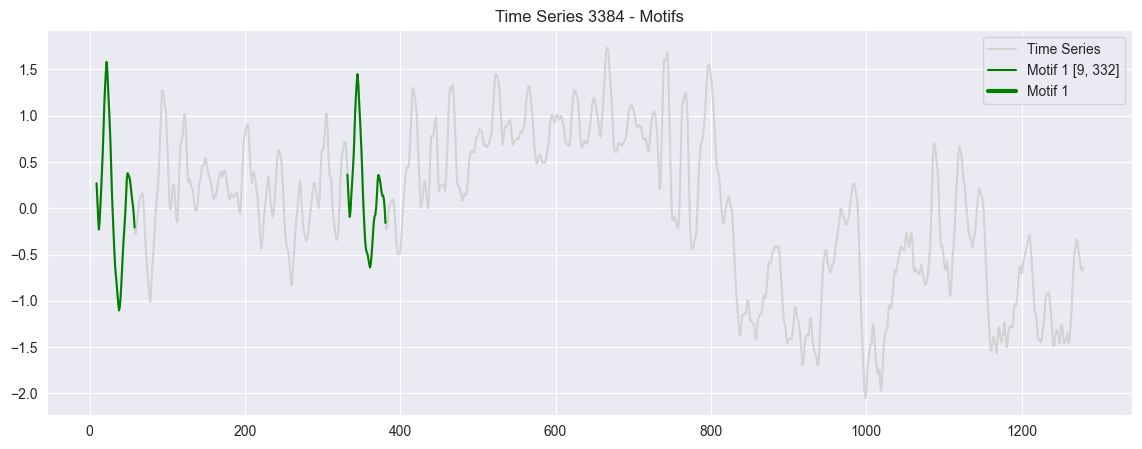

2EuPcc2kzFNbv3Ec2BAPLp
minimal-techno


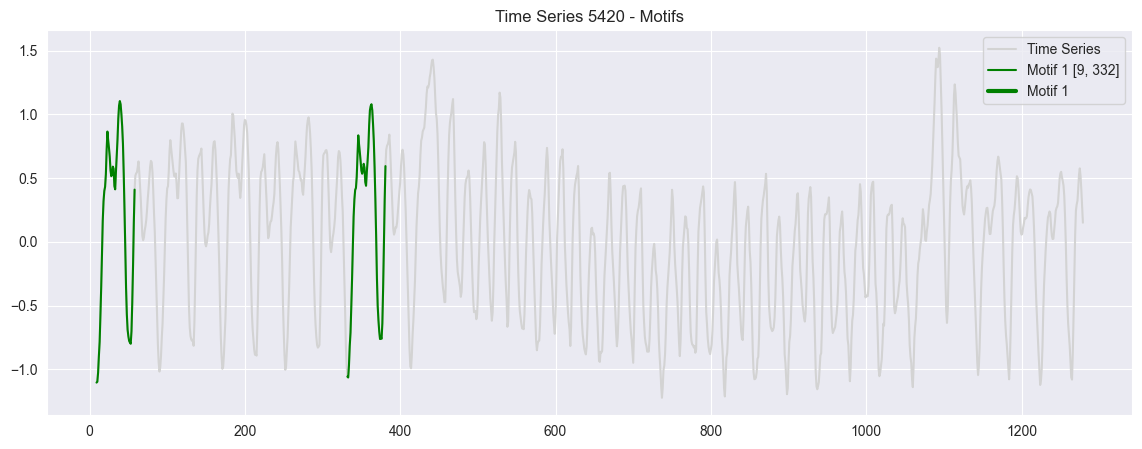

22PTmk4mzAVi92WiQPAcFp
progressive-house


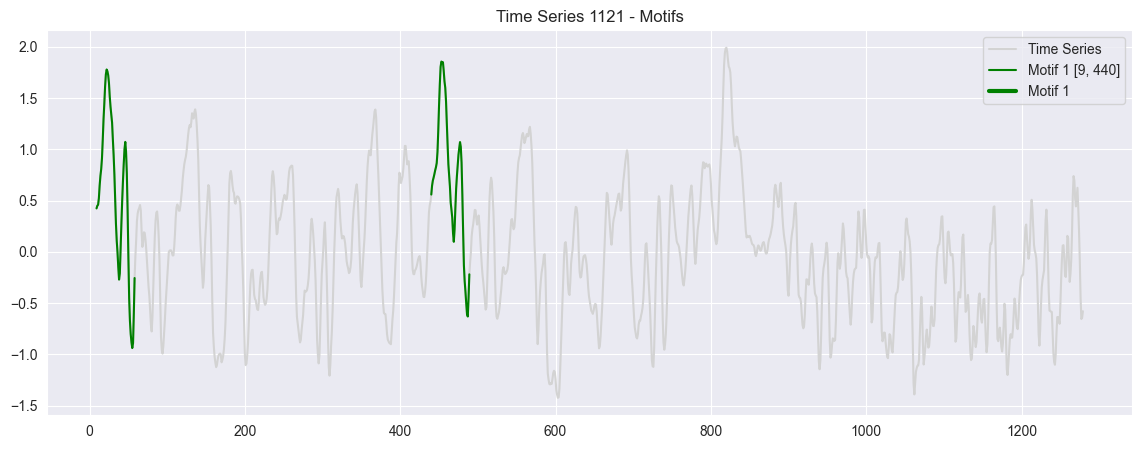

4Y15YTzMj1LkCGSpgd1GhU
sertanejo


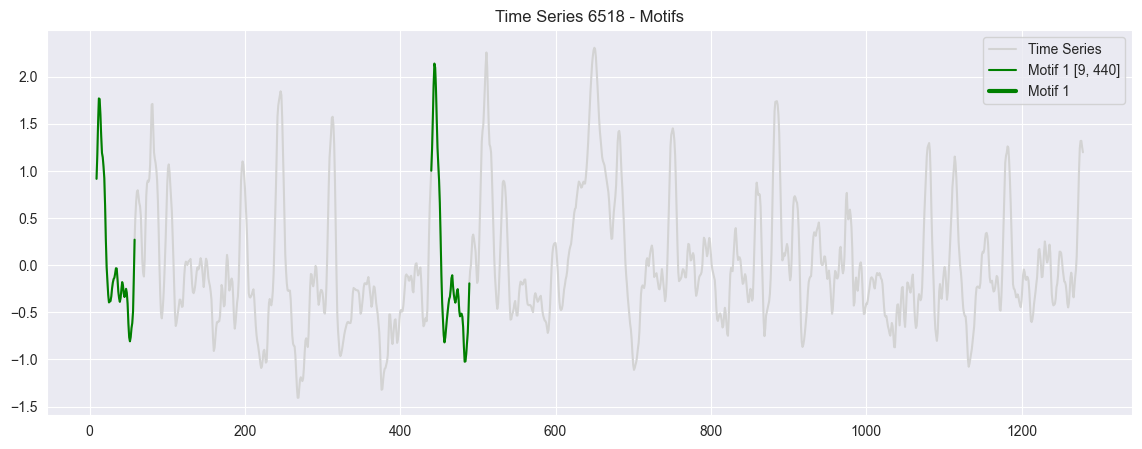

5Axapk6xMmSHK2A75EZiYo
progressive-house


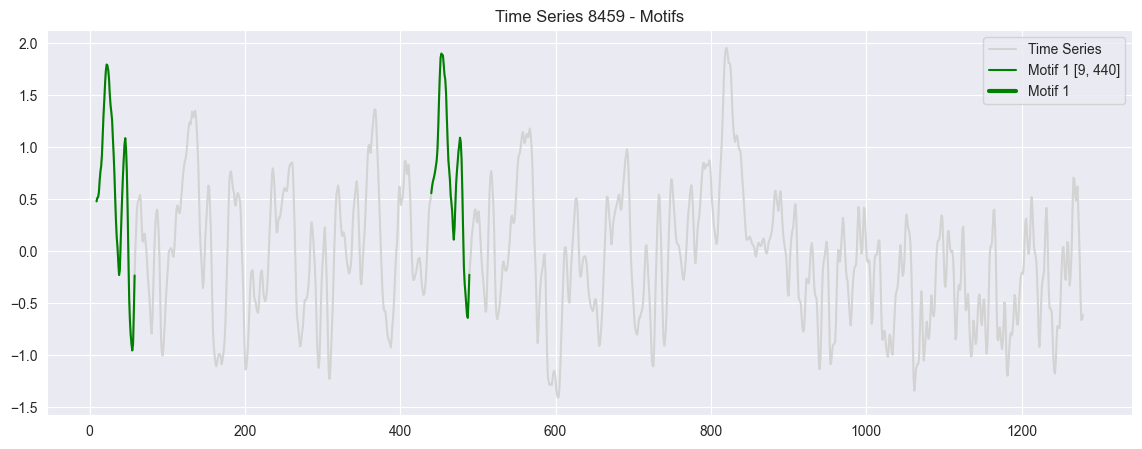

1ml3WGeluftee3DiSfyIGx
songwriter


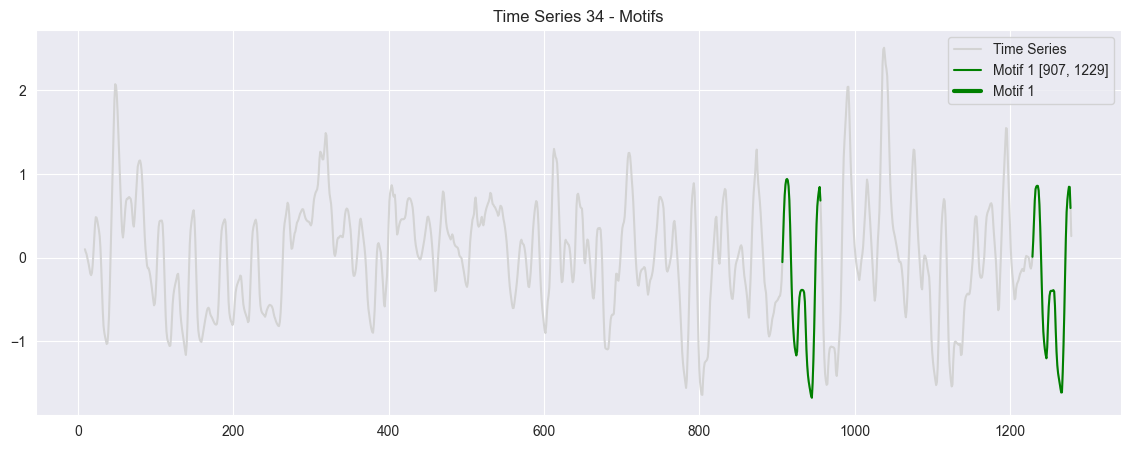

2Xb6wJYGi0QXwURw5WWvI5
songwriter


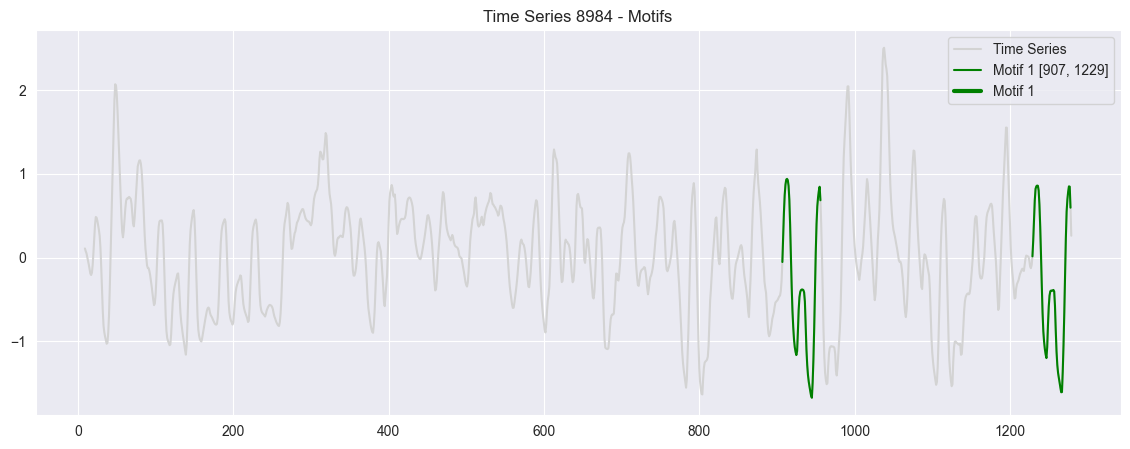

0ZaV9t2HCfhv5VQiI3RfxV
happy


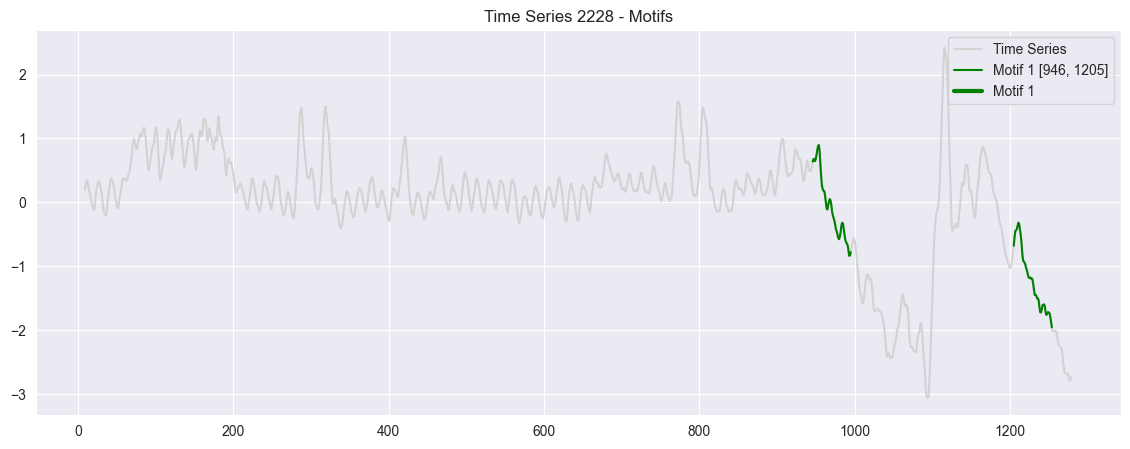

79JqhhT62bJSWP7OqQPlnc
piano


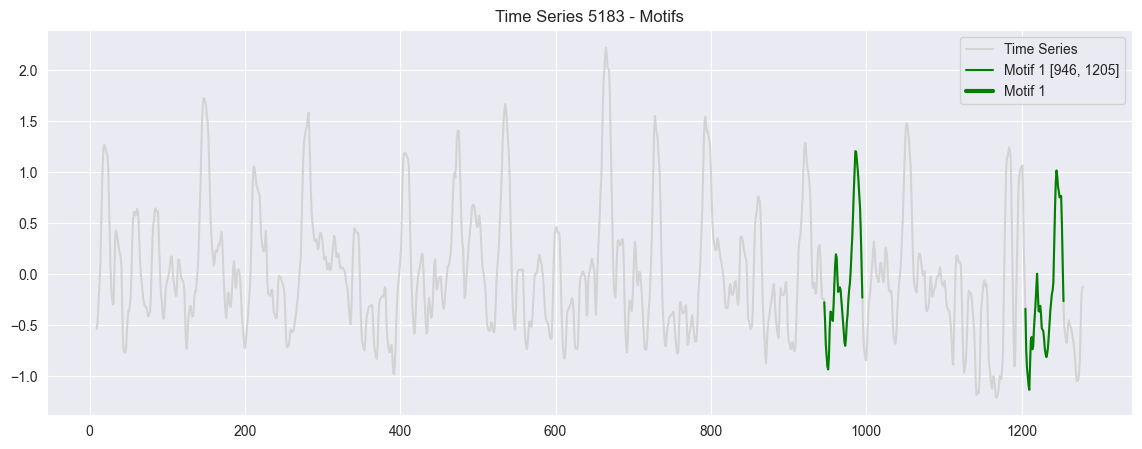

6LyA7ACKgmVyPfiuIwC5E0
heavy-metal


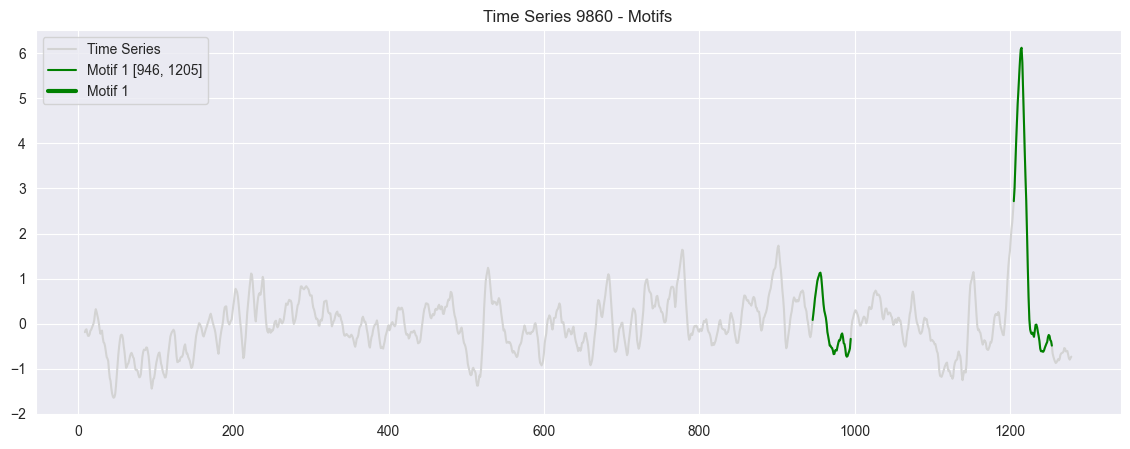

49uBqsqkSRTufWYBadrKLx
world-music


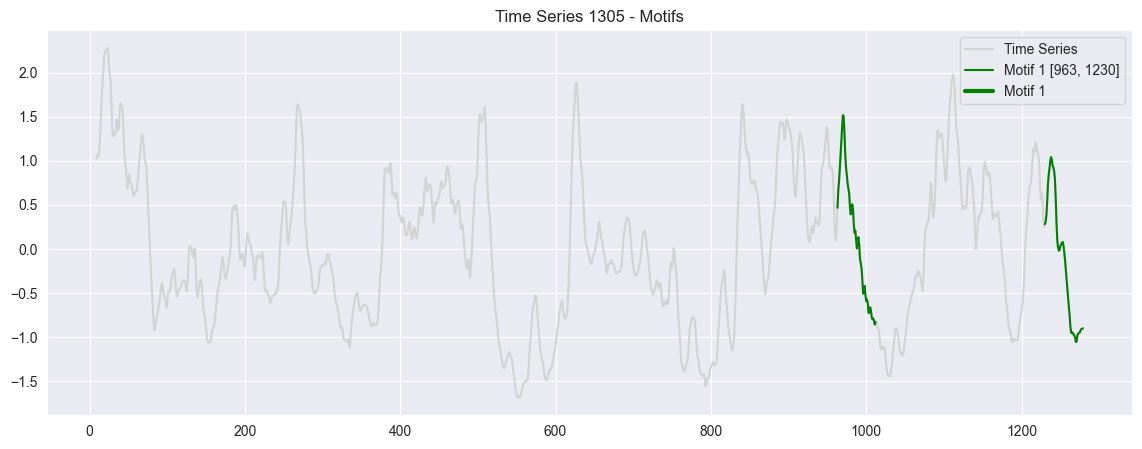

61dgKii1YUE2sS7SZk00Ky
minimal-techno


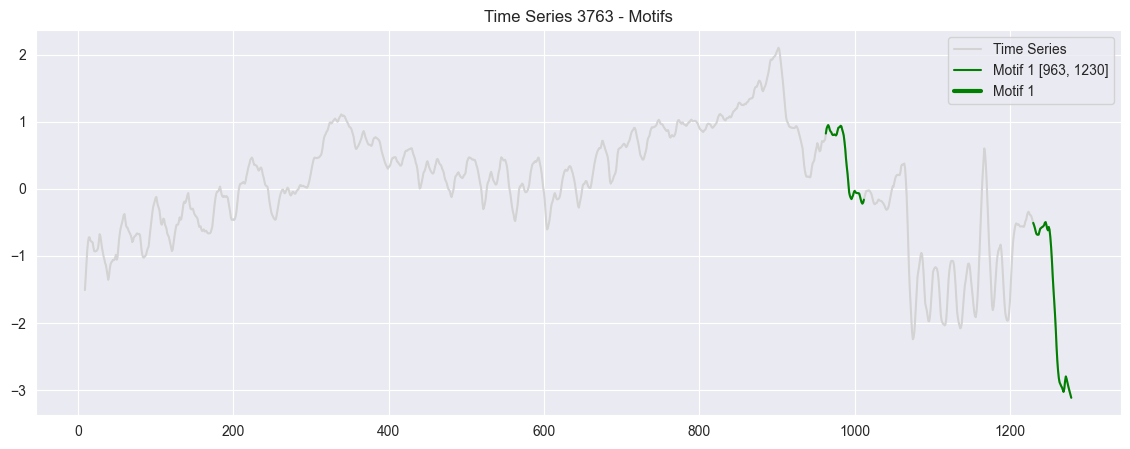

46MhfQQxeAHPhycIbDs9Gc
j-idol


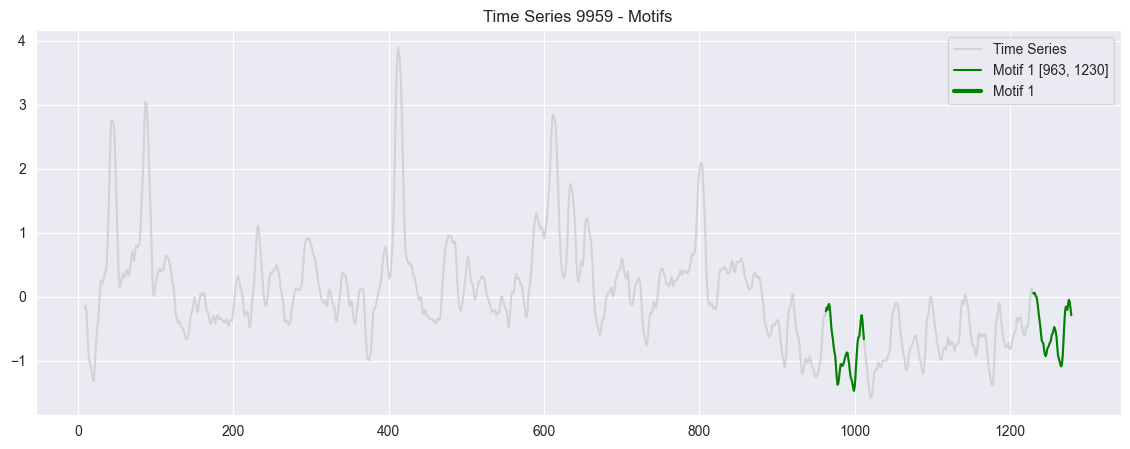

51xQ0wGnOR8Sy5ce2UmVLi
heavy-metal


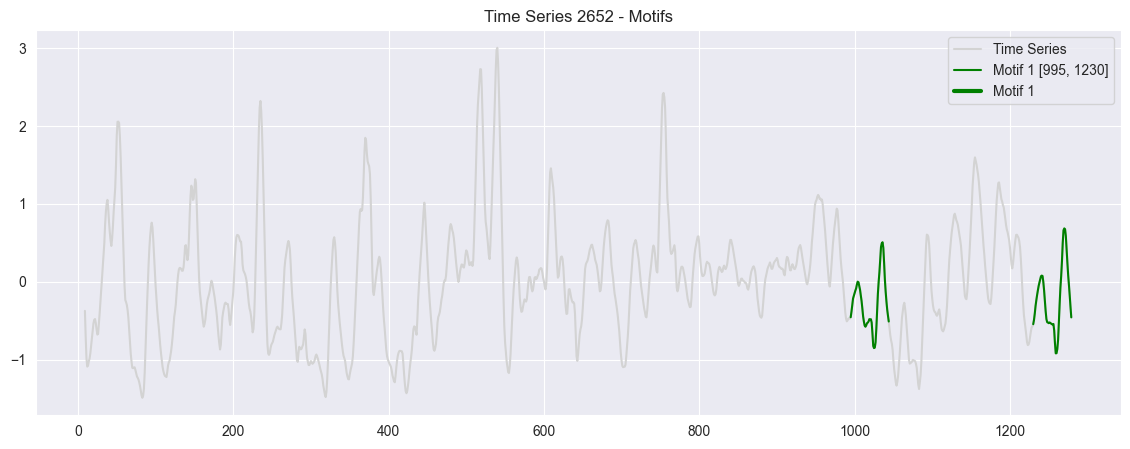

2YNgcIiD73XsXFNM3UuxlM
folk


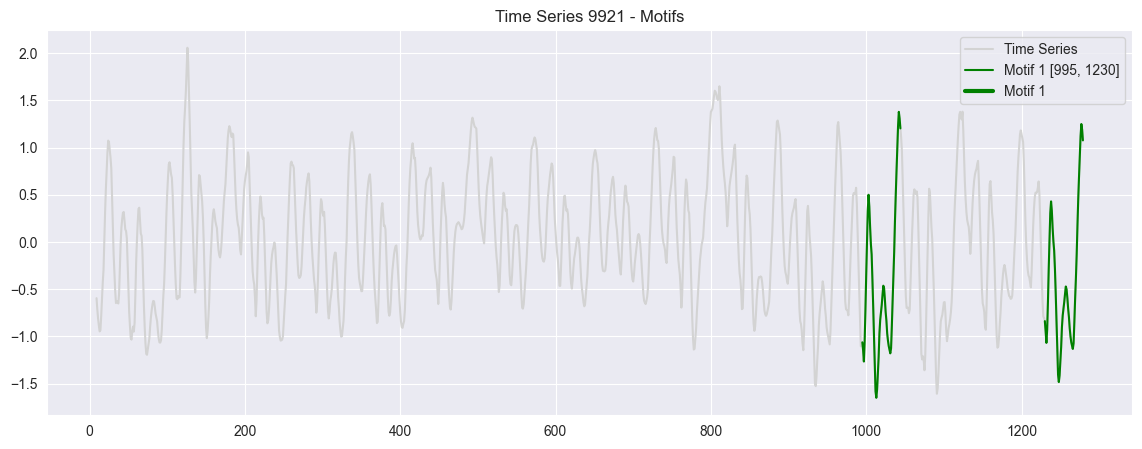

4U0rgCu3sVS4UvJ4cv6ueJ
world-music


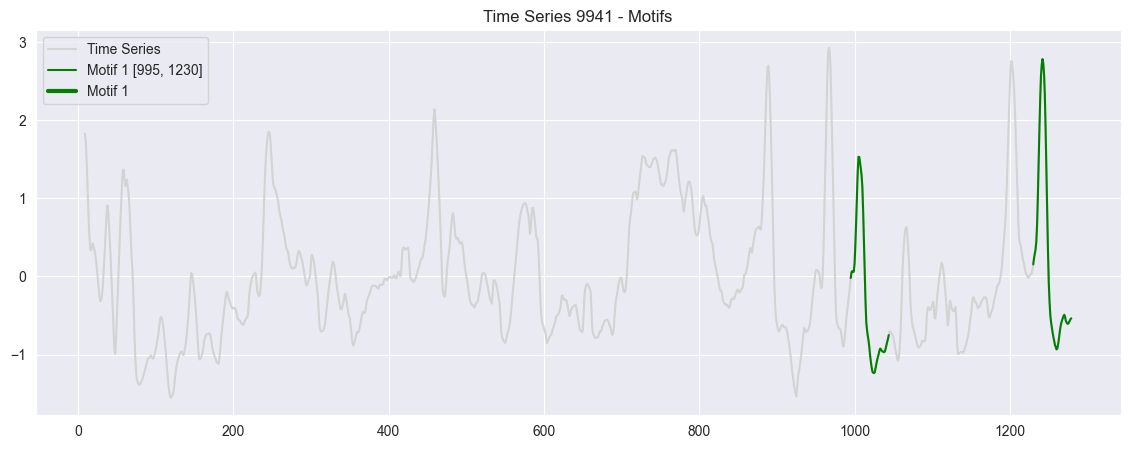

In [156]:
# Number of time series
num_series = 3

motif_copy = all_motifs[all_motifs['n_duplicated'] > 2]
# drop duplicated ids from motif_copy
motif_copy = motif_copy.drop_duplicates(subset='id', keep='first')

colors = ['g', 'k', 'b', 'y']
# Plotting each series' motifs and discords
for series_id in motif_copy['index'].unique():
    # Load motifs and discords from CSV
    best_motif = motif_copy[motif_copy['index'] == series_id]

    # Assuming you have the original time series data in 'X'
    ts = X[series_id, -1].T
    
    print(ids[series_id])
    print(y[series_id])


# Create a plot for the time series and its motifs/discords
    plt.figure(figsize=(14, 5))
    plt.title(f"Time Series {series_id} - Motifs")
    plt.plot(ts, label='Time Series', color='lightgray')

    # Highlight motifs and discords
    color_index = 0
    for index, motif in enumerate(best_motif['Motifs']):
        motif_indices = ast.literal_eval(motif)  # Convert string back to list
        color = colors[color_index % len(colors)]  # Cycle through colors
        for start_index in motif_indices:
            plt.plot(range(start_index, start_index + w), ts[start_index:start_index + w], label=f'Motif {index + 1} {motif_indices}', color=color)
        plt.plot([], [], color=color, label=f'Motif {index + 1}', linewidth=3)  # Add legend entry
        color_index += 1


    # Ensure legends are not repeatedly added
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

# Shapelets

In [ ]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.preprocessing import LabelEncoder

Shapelets are subsequences that can be used to represent a class. Matrix profiles make it possibile to identify these shapelets.

In [ ]:
# I need to convert the data genres in y to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# And that's how we can convert them back
le.inverse_transform([y[0]])

In [ ]:
X.shape

In [ ]:
# To work with the tslearn library, we need to reshape the data where the first dimension is the number of time series, the second dimension is the number of points in each time series, and the third dimension is the number of dimensions (in this case, 1 since we have univariate time series).
X_reshaped = X.reshape(X.shape[0], X.shape[2], X.shape[1])

X_reshaped.shape

In [ ]:
formatted_dataset = to_time_series_dataset(X_reshaped)

In [ ]:
formatted_dataset.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(formatted_dataset, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
adam = Adam(learning_rate=0.01)

In [ ]:
%%time
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {50: 1}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=adam,
                            max_iter=250,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train[:5], y_train[:5])

In [ ]:
# We can extract the shapelets from the model
shapelets = shp_clf.shapelets_
shapelets

In [ ]:
# Try to predict the class of the time series
shp_clf.predict(X_test[:5])

In [ ]:
# Check if the predictions are correct
shp_clf.score(X_test[:5], y_test[:5])

In [ ]:
print(X_train[:5])
print(y_train[:5])

In [ ]:
for shp_idx, shp in enumerate(shapelets):
    print(f"Shapelet {shp_idx} - Length {len(shp)}")
    print(shp)

In [ ]:
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train[:5])
predicted_locations = shp_clf.locate(X_train[:5])

In [ ]:
# Plot the shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.title("Learned shapelet of size %d" % sz)
    plt.plot(shapelets[i].ravel())
plt.show()

In [ ]:
num_instances = 5

# Set up the figure and subplots
fig, axs = plt.subplots(num_instances, 1, figsize=(10, num_instances * 3))

# Iterate through each instance and corresponding axes
for idx, ax in enumerate(axs):
    # Plot the time series
    ax.plot(X_train[idx].ravel(), "r-", label='Time Series')

    # Find and plot each shapelet
    for shp_idx, shp in enumerate(shapelets):
        # Get the start position of this shapelet in the time series
        start_pos = predicted_locations[idx, shp_idx]

        if start_pos != -1:  # Only plot if the shapelet matches the time series
            # Extract the segment of the time series where the shapelet matches
            matched_segment = X_train[idx, start_pos:start_pos + len(shp)].ravel()
            ax.plot(range(start_pos, start_pos + len(shp)), matched_segment, "g-", linewidth=2, label='Shapelet Match' if shp_idx == 0 else "")
            
            

    # Enhance plot
    ax.legend()
    ax.set_title(f"Time Series {idx + 1} with Shapelet Matches")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()